In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
# import scipy.stats as stats
# import statsmodels.api as sm
import miceforest as mf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error


from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


from tqdm import tqdm
import os



from tensorflow.keras.layers import Lambda, Dropout, Concatenate
from tensorflow.keras import losses
from tensorflow.keras import backend as K
from sklearn.metrics import mean_absolute_error, mean_squared_error as sk_mse




from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer
import warnings
import time
warnings.filterwarnings('ignore')


from sklearn.base import BaseEstimator, TransformerMixin

import random
from sklearn.model_selection import KFold
from scipy.stats import ks_2samp

from sklearn.ensemble import RandomForestRegressor

# Data Import + only Baseline

In [14]:
# Read the CSV file - linked file 
file_path = "Merged_TSQIC_REDCap_ACCESS.xlsx" 
df = pd.read_excel(file_path)
df

,id,operation_date,redcap_event_name,ComplicationDate,dob,qol_date,age_diagnosis,gender,overall_primary_tumour,overall_regional_ln,...,a_e5,a_e6,a_e7,a_c6,a_c2,a_act11,readmission_30d,postop_comp,los,DischargeDate
0,1,NaT,baseline_arm_1,NaT,2049-08-04,NaT,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,2012-04-27
1,1,2011-08-26,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-08-26
2,1,2010-02-20,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,2010-03-08
3,1,2009-02-25,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,2009-03-05
4,1,2008-02-22,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,2008-03-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18182,1770,NaT,preoperative_arm_1,NaT,NaT,NaT,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
18183,1770,NaT,preoperative_arm_1,NaT,NaT,NaT,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
18184,1770,NaT,preoperative_arm_1,NaT,NaT,2025-02-24,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,3.0,3.0,NaN,NaN,NaN,NaT
18185,1770,NaT,baseline_arm_1,NaT,1982-10-12,NaT,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


                              ge1         ge2         ge3         ge4  \
1_month_postop_arm_1    44.060150   43.909774   45.112782   44.360902   
1_year_postop_arm_1      5.820106    5.820106    6.878307    5.291005   
2_years_postop_arm_1     3.921569    3.921569    3.921569    3.921569   
3_months_postop_arm_1    2.702703    4.729730    4.054054    3.378378   
3_years_postop_arm_1     6.410256    8.974359    7.692308    6.410256   
4_years_postop_arm_1     4.347826    6.521739    4.347826    4.347826   
5_years_postop_arm_1    94.918567   94.983713   94.918567   94.918567   
6_months_postop_arm_1    3.174603    3.703704    3.703704    4.232804   
baseline_arm_1          47.491448   48.916762   50.969213   48.289624   
preoperative_arm_1      74.343832   74.409449   74.540682   74.278215   
surgery_arm_1          100.000000  100.000000  100.000000  100.000000   

                              ge5         ge6  
1_month_postop_arm_1    44.210526   44.060150  
1_year_postop_arm_1      5.

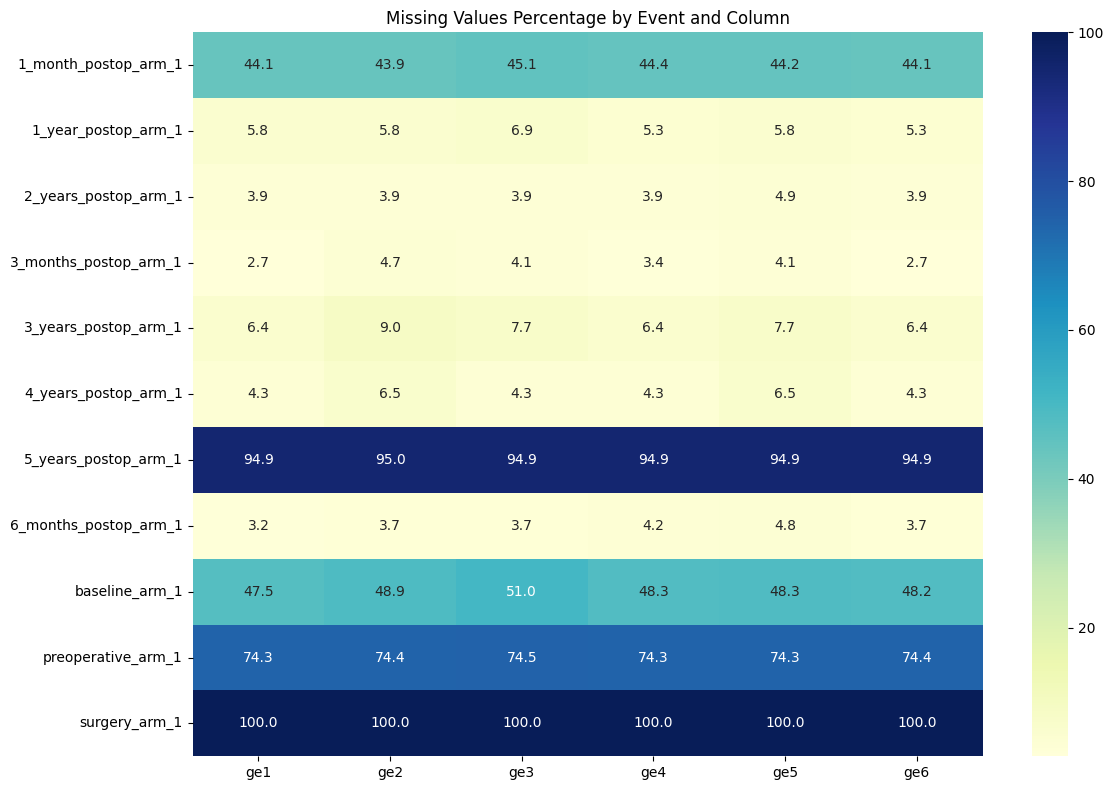

In [15]:
# First, let's create a function to calculate missing value percentages
def calculate_missing_percentages(df, columns, group_col):
    # Group by both id and the specified column to handle multiple rows per (id, group_col)
    grouped = df.groupby(['id', group_col])
    
    # Aggregate by taking the first non-null value for each (id, group_col) combination
    aggregated_df = grouped[columns].apply(lambda x: x.bfill().ffill().iloc[0] if len(x) > 0 else pd.Series([None] * len(columns), index=columns))
    aggregated_df = aggregated_df.reset_index()
    
    # Now group by the specified column only
    grouped_by_event = aggregated_df.groupby(group_col)
    
    # Initialize a dictionary to store results
    missing_percentages = {}
    
    # Calculate missing percentages for each group
    for name, group in grouped_by_event:
        # Calculate percentage of missing values for each column
        missing_pct = group[columns].isna().mean() * 100
        missing_percentages[name] = missing_pct
    
    # Convert to DataFrame for better visualization
    result_df = pd.DataFrame(missing_percentages)
    return result_df.T # Transpose for better readability

# Columns of interest
ge_columns = ['ge1', 'ge2', 'ge3', 'ge4', 'ge5', 'ge6']

# Calculate missing percentages for each redcap_event_name
missing_pct_by_event = calculate_missing_percentages(df, ge_columns, 'redcap_event_name')

# Display the results
print(missing_pct_by_event)

plt.figure(figsize=(12, 8))
sns.heatmap(missing_pct_by_event, annot=True, cmap='YlGnBu', fmt='.1f')
plt.title('Missing Values Percentage by Event and Column')
plt.tight_layout()
plt.show()

In [16]:
# # Leave only baseline
df = df[df['redcap_event_name'] == 'baseline_arm_1']
df

,id,operation_date,redcap_event_name,ComplicationDate,dob,qol_date,age_diagnosis,gender,overall_primary_tumour,overall_regional_ln,...,a_e5,a_e6,a_e7,a_c6,a_c2,a_act11,readmission_30d,postop_comp,los,DischargeDate
0,1,NaT,baseline_arm_1,NaT,2049-08-04,NaT,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,2012-04-27
14,1,NaT,baseline_arm_1,NaT,NaT,NaT,NaN,NaN,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
18,2,NaT,baseline_arm_1,NaT,NaT,NaT,NaN,NaN,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
22,2,NaT,baseline_arm_1,NaT,2041-02-25,NaT,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
25,2,NaT,baseline_arm_1,NaT,NaT,2007-01-12,NaN,NaN,NaN,NaN,...,0.0,4.0,0.0,4.0,0.0,1.0,NaN,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18178,1769,NaT,baseline_arm_1,NaT,NaT,NaT,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
18179,1769,NaT,baseline_arm_1,NaT,NaT,2025-03-10,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,1.0,NaN,NaN,NaN,NaT
18180,1769,NaT,baseline_arm_1,NaT,NaT,NaT,NaN,NaN,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
18181,1770,NaT,baseline_arm_1,NaT,NaT,NaT,42.054252,NaN,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [17]:
df.columns

Index(['id', 'operation_date', 'redcap_event_name', 'ComplicationDate', 'dob',
       'qol_date', 'age_diagnosis', 'gender', 'overall_primary_tumour',
       'overall_regional_ln', 'overall_distant_metastasis', 'neotx___notx',
       'neotx___chemo', 'neotx___rads', 'neotx___chemorads', 'neotx___immuno',
       'neotx___other', 'procedure123456', 'expectation_treatment',
       'path_esoph_primtumour', 'path_esoph_regionalln',
       'path_esoph_distantmetast', 'gp1', 'gp2', 'gp3', 'gp4', 'gp5', 'gp6',
       'gp7', 'gs1', 'gs2', 'gs3', 'gs4', 'gs5', 'gs6', 'gs7', 'ge1', 'ge2',
       'ge3', 'ge4', 'ge5', 'ge6', 'gf1', 'gf2', 'gf3', 'gf4', 'gf5', 'gf6',
       'gf7', 'a_hn1', 'a_hn2', 'a_hn3', 'a_hn4', 'a_hn5', 'a_hn7', 'a_hn10',
       'a_e1', 'a_e2', 'a_e3', 'a_e4', 'a_e5', 'a_e6', 'a_e7', 'a_c6', 'a_c2',
       'a_act11', 'readmission_30d', 'postop_comp', 'los', 'DischargeDate'],
      dtype='object')

In [18]:
#drop dates
df = df.drop(columns=["ComplicationDate", "dob", "operation_date", "DischargeDate"]) #qol_date
df.columns

Index(['id', 'redcap_event_name', 'qol_date', 'age_diagnosis', 'gender',
       'overall_primary_tumour', 'overall_regional_ln',
       'overall_distant_metastasis', 'neotx___notx', 'neotx___chemo',
       'neotx___rads', 'neotx___chemorads', 'neotx___immuno', 'neotx___other',
       'procedure123456', 'expectation_treatment', 'path_esoph_primtumour',
       'path_esoph_regionalln', 'path_esoph_distantmetast', 'gp1', 'gp2',
       'gp3', 'gp4', 'gp5', 'gp6', 'gp7', 'gs1', 'gs2', 'gs3', 'gs4', 'gs5',
       'gs6', 'gs7', 'ge1', 'ge2', 'ge3', 'ge4', 'ge5', 'ge6', 'gf1', 'gf2',
       'gf3', 'gf4', 'gf5', 'gf6', 'gf7', 'a_hn1', 'a_hn2', 'a_hn3', 'a_hn4',
       'a_hn5', 'a_hn7', 'a_hn10', 'a_e1', 'a_e2', 'a_e3', 'a_e4', 'a_e5',
       'a_e6', 'a_e7', 'a_c6', 'a_c2', 'a_act11', 'readmission_30d',
       'postop_comp', 'los'],
      dtype='object')

In [19]:
# Step 1: Preprocess categorical variables
# Low-cardinality variables: Convert to category dtype
low_cardinality_cols = [
    'postop_comp', 'readmission_30d', 'gender', 'neotx___notx', 'neotx___chemo',
    'neotx___rads', 'neotx___chemorads', 'neotx___immuno', 'neotx___other',
    'expectation_treatment'
]
for col in low_cardinality_cols:
    df[col] = df[col].astype('category')

# High-cardinality variables: Label encode and convert to category
le_redcap = LabelEncoder()
df['redcap_event_name'] = df['redcap_event_name'].astype(str)  # Convert to string to handle NaN
df['redcap_event_name'] = le_redcap.fit_transform(df['redcap_event_name'])
df['redcap_event_name'] = df['redcap_event_name'].astype('category')

# procedure123456 is already numerical but should be treated as categorical
df['procedure123456'] = df['procedure123456'].astype('category')
df

,id,redcap_event_name,qol_date,age_diagnosis,gender,overall_primary_tumour,overall_regional_ln,overall_distant_metastasis,neotx___notx,neotx___chemo,...,a_e4,a_e5,a_e6,a_e7,a_c6,a_c2,a_act11,readmission_30d,postop_comp,los
0,1,0,NaT,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
14,1,0,NaT,NaN,NaN,2,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,2,0,NaT,NaN,NaN,3,1,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,2,0,NaT,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,2,0,2007-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,4.0,0.0,4.0,0.0,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18178,1769,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18179,1769,0,2025-03-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,NaN,NaN
18180,1769,0,NaT,NaN,NaN,3,1,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18181,1770,0,NaT,42.054252,NaN,3,0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# Step 2: Preprocess numerical and ordinal columns
# True numerical columns: Ensure float/int dtype
numerical_cols = ['los', 'age_diagnosis']
for col in numerical_cols:
    df[col] = df[col].astype(float)

#Step 3
# Ordinal columns: Treat as numerical (already float)
ordinal_cols = (
    [f"gp{i}" for i in range(1, 8)] + [f"gs{i}" for i in range(1, 8)] +
    [f"ge{i}" for i in range(1, 7)] + [f"gf{i}" for i in range(1, 8)] +
    [f"a_hn{i}" for i in range(1, 6)] + ["a_hn7", "a_hn10"] +
    [f"a_e{i}" for i in range(1, 8)] + ["a_c6", "a_c2", "a_act11"]
)
# Subset for this example
ordinal_cols = [col for col in ordinal_cols if col in df.columns]
for col in ordinal_cols:
    df[col] = df[col].astype(float)

#Step 4
# Categorical-like columns: Treat as categorical
categorical_like_cols = [
    'overall_primary_tumour', 'overall_regional_ln', 'overall_distant_metastasis', 
    'path_esoph_primtumour', 'path_esoph_regionalln', 'path_esoph_distantmetast'
]
for col in categorical_like_cols:
    df[col] = df[col].astype(str)  # Convert to string to handle mixed types
    df[col] = df[col].astype('category')
df

,id,redcap_event_name,qol_date,age_diagnosis,gender,overall_primary_tumour,overall_regional_ln,overall_distant_metastasis,neotx___notx,neotx___chemo,...,a_e4,a_e5,a_e6,a_e7,a_c6,a_c2,a_act11,readmission_30d,postop_comp,los
0,1,0,NaT,NaN,1.0,nan,nan,nan,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
14,1,0,NaT,NaN,NaN,2,0,nan,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,2,0,NaT,NaN,NaN,3,1,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,2,0,NaT,NaN,1.0,nan,nan,nan,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,2,0,2007-01-12,NaN,NaN,nan,nan,nan,NaN,NaN,...,3.0,0.0,4.0,0.0,4.0,0.0,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18178,1769,0,NaT,NaN,NaN,nan,nan,nan,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18179,1769,0,2025-03-10,NaN,NaN,nan,nan,nan,NaN,NaN,...,2.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,NaN,NaN
18180,1769,0,NaT,NaN,NaN,3,1,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18181,1770,0,NaT,42.054252,NaN,3,0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:

def analyze_categorical_columns(dataframe):
    """
    Analyzes all categorical columns in a dataframe to check if they contain only one unique value.
    
    Args:
        dataframe: pandas DataFrame to analyze
        
    Returns:
        dict: Dictionary with column names as keys and tuples (has_single_category, unique_value) as values
    """
    results = {}
    
    # Identify categorical columns
    # This includes object dtype, category dtype, and any other non-numeric columns
    categorical_columns = dataframe.select_dtypes(
        include=['object', 'category', 'bool']
    ).columns.tolist()
    
    # For each categorical column, check if it has only one unique value
    for column in categorical_columns:
        # Skip columns with all null values
        if dataframe[column].isna().all():
            results[column] = (False, None, "All values are null")
            continue
            
        # Get unique non-null values
        unique_values = dataframe[column].dropna().unique()
        
        # Check if there's only one unique category
        has_single_category = len(unique_values) == 1
        
        if has_single_category:
            results[column] = (True, unique_values[0], None)
        else:
            results[column] = (False, None, f"Found {len(unique_values)} unique values")
    
    return results

# Example usage:
column_analysis = analyze_categorical_columns(df)

# Print results
for column, (has_single_value, unique_value, message) in column_analysis.items():
    if has_single_value:
        print(f"Column '{column}' has only one unique value: {unique_value}")

Column 'redcap_event_name' has only one unique value: 0
Column 'path_esoph_primtumour' has only one unique value: nan
Column 'path_esoph_regionalln' has only one unique value: nan
Column 'path_esoph_distantmetast' has only one unique value: nan


In [22]:
def drop_single_value_categorical_columns(dataframe, inplace=False):
    """
    Identifies and drops all categorical columns that contain only one unique value.
    
    Args:
        dataframe: pandas DataFrame to process
        inplace: Whether to modify the original dataframe (True) or return a copy (False)
        
    Returns:
        DataFrame: Modified dataframe with single-value categorical columns removed
        list: List of column names that were dropped
    """
    # Make a copy if not inplace
    df = dataframe if inplace else dataframe.copy()
    
    # Identify categorical columns
    categorical_columns = df.select_dtypes(
        include=['object', 'category', 'bool']
    ).columns.tolist()
    
    # Track columns to drop
    columns_to_drop = []
    
    # Check each categorical column
    for column in categorical_columns:
        # Skip columns with all null values
        if df[column].isna().all():
            continue
            
        # Get unique non-null values
        unique_values = df[column].dropna().unique()
        
        # If only one unique value, add to drop list
        if len(unique_values) == 1:
            columns_to_drop.append(column)
    
    # Drop the identified columns
    if columns_to_drop:
        df.drop(columns=columns_to_drop, inplace=True)
        
    return df, columns_to_drop

# Example usage:
# Drop single-value categorical columns
df_cleaned, dropped_columns = drop_single_value_categorical_columns(df, inplace=False)

# Report results
if dropped_columns:
    print(f"Dropped {len(dropped_columns)} columns with only one unique value:")
    for col in dropped_columns:
        print(f"  - {col}")
else:
    print("No single-value categorical columns found.")

df = df_cleaned.copy()

Dropped 4 columns with only one unique value:
  - redcap_event_name
  - path_esoph_primtumour
  - path_esoph_regionalln
  - path_esoph_distantmetast


# Classification process + metrics 

In [25]:
# Add these imports at the top of your file
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_score, recall_score

def process_for_classification(values, min_val=0, max_val=4):
    """
    Process imputed values for classification evaluation
    
    Parameters:
    -----------
    values : array-like
        Raw imputed values
    min_val : int
        Minimum allowed value (default: 0)
    max_val : int  
        Maximum allowed value (default: 4)
        
    Returns:
    --------
    numpy.ndarray
        Processed values as integers in range [min_val, max_val]
    """
    # Round to nearest integer
    rounded = np.round(values)
    # Clip to valid range
    clipped = np.clip(rounded, min_val, max_val)
    return clipped.astype(int)

In [26]:
def calculate_classification_metrics(y_true, y_pred, classes=None):
    """
    Calculate classification metrics for multi-class problem
    
    Parameters:
    -----------
    y_true : array-like
        True class labels
    y_pred : array-like
        Predicted class labels
    classes : array-like, optional
        Class labels (default: [0, 1, 2, 3, 4])
        
    Returns:
    --------
    dict
        Dictionary containing classification metrics
    """
    if classes is None:
        classes = np.array([0, 1, 2, 3, 4])
    
    try:
        # Convert to numpy arrays
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        
        # Basic accuracy
        accuracy = accuracy_score(y_true, y_pred)
        
        # Macro-averaged metrics (average across classes)
        precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
        recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
        
        # Weighted-averaged metrics (weighted by class frequency)
        precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        
        # For multi-class AUC, we need to binarize the labels
        try:
            # Only calculate AUC if we have more than one class present
            if len(np.unique(y_true)) > 1:
                y_true_bin = label_binarize(y_true, classes=classes)
                y_pred_bin = label_binarize(y_pred, classes=classes)
                
                # If only 2 classes present, reshape
                if y_true_bin.shape[1] == 1:
                    auc_score = roc_auc_score(y_true_bin, y_pred_bin)
                else:
                    # Multi-class AUC (macro average)
                    auc_score = roc_auc_score(y_true_bin, y_pred_bin, average='macro', multi_class='ovr')
            else:
                auc_score = np.nan
        except:
            auc_score = np.nan
        
        # Per-class metrics
        cm = confusion_matrix(y_true, y_pred, labels=classes)
        
        # Calculate sensitivity (recall) and specificity for each class
        per_class_metrics = {}
        for i, class_label in enumerate(classes):
            if i < cm.shape[0] and i < cm.shape[1]:
                tp = cm[i, i] if i < cm.shape[0] and i < cm.shape[1] else 0
                fp = cm[:, i].sum() - tp if i < cm.shape[1] else 0
                fn = cm[i, :].sum() - tp if i < cm.shape[0] else 0
                tn = cm.sum() - tp - fp - fn
                
                # Sensitivity (recall/true positive rate)
                sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
                
                # Specificity (true negative rate)
                specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
                
                # PPV (precision)
                ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
                
                # NPV
                npv = tn / (tn + fn) if (tn + fn) > 0 else 0
                
                per_class_metrics[f'class_{class_label}'] = {
                    'sensitivity': sensitivity,
                    'specificity': specificity,
                    'ppv': ppv,
                    'npv': npv
                }
        
        # Average across classes for summary
        avg_sensitivity = np.mean([metrics['sensitivity'] for metrics in per_class_metrics.values()])
        avg_specificity = np.mean([metrics['specificity'] for metrics in per_class_metrics.values()])
        avg_ppv = np.mean([metrics['ppv'] for metrics in per_class_metrics.values()])
        avg_npv = np.mean([metrics['npv'] for metrics in per_class_metrics.values()])
        
        return {
            'accuracy': accuracy,
            'auc_multiclass': auc_score,
            'precision_macro': precision_macro,
            'recall_macro': recall_macro,
            'precision_weighted': precision_weighted,
            'recall_weighted': recall_weighted,
            'avg_sensitivity': avg_sensitivity,
            'avg_specificity': avg_specificity,
            'avg_ppv': avg_ppv,
            'avg_npv': avg_npv,
            'per_class_metrics': per_class_metrics,
            'confusion_matrix': cm
        }
        
    except Exception as e:
        print(f"Error calculating classification metrics: {e}")
        return {
            'accuracy': np.nan,
            'auc_multiclass': np.nan,
            'precision_macro': np.nan,
            'recall_macro': np.nan,
            'precision_weighted': np.nan,
            'recall_weighted': np.nan,
            'avg_sensitivity': np.nan,
            'avg_specificity': np.nan,
            'avg_ppv': np.nan,
            'avg_npv': np.nan,
            'per_class_metrics': {},
            'confusion_matrix': None
        }

# Model - MICE

In [27]:
def apply_mice_imputation(df, columns_to_impute, validation_df=None, validation_masks=None, original_values=None):
    """
    Apply MICE imputation using miceforest package
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Data with missing values
    columns_to_impute : list
        List of column names to impute
    validation_df : pandas.DataFrame, optional
        Validation dataset with artificially missing values
    validation_masks : dict, optional
        Dictionary of masks for validation data
    original_values : dict, optional
        Dictionary of original values for validation
        
    Returns:
    --------
    imputed_df : pandas.DataFrame
        Data with imputed values
    validation_results : dict, optional
        Validation results if validation data provided
    """

    # Set threads for LightGBM
    os.environ['OMP_NUM_THREADS'] = '10'
    
    # Initialize the imputation kernel
    kernel = mf.ImputationKernel(
        df,
        datasets=1,
        variable_schema={
            col: [c for c in df.columns if c != col] for col in columns_to_impute
        },
        random_state=42  # Using fixed seed for reproducibility, can be parameterized
    )
    
    # Run imputation
    for _ in tqdm(range(5), desc="MICE Imputation"):
        kernel.mice(
            iterations=1,
            verbose=False,
            num_boost_round=80,
            max_depth=10,
            num_threads=10
        )
    
    # Get imputed data
    imputed_df = kernel.complete_data(0)
    
    # Check if there's a label encoder for redcap_event_name that needs inverse transformation
    if 'redcap_event_name' in imputed_df.columns:
        try:
            # This is optional - only execute if le_redcap exists in the global scope
            if 'le_redcap' in globals():
                # Check if we're dealing with numeric values (could be int or float)
                if pd.api.types.is_numeric_dtype(imputed_df['redcap_event_name']) or \
                   (hasattr(imputed_df['redcap_event_name'], 'cat') and pd.api.types.is_numeric_dtype(imputed_df['redcap_event_name'].cat.categories)):
                    imputed_df['redcap_event_name'] = globals()['le_redcap'].inverse_transform(imputed_df['redcap_event_name'].astype(int))
        except Exception as e:
            print(f"Warning: Could not inverse transform redcap_event_name: {e}")
    
    # Validate if validation data provided
    validation_results = None
    if validation_df is not None and validation_masks is not None and original_values is not None:
        validation_results = {}
        
        # Compare imputed values to real values
        for col in columns_to_impute:
            # Get indices where values were artificially set to NaN
            mask = validation_masks[col] & validation_df[col].isna()
            
            if mask.sum() == 0:
                validation_results[col] = {
                    'error': "No artificially missing values"
                }
                continue
                
            real_vals = original_values[col][mask]
            imputed_vals = imputed_df[col][mask]
            
            # Calculate continuous metrics (MAE and RMSE) - NO ROUNDING
            mae = mean_absolute_error(real_vals, imputed_vals)
            rmse = np.sqrt(mean_squared_error(real_vals, imputed_vals))
            
            # Calculate classification metrics - WITH ROUNDING
            real_vals_class = process_for_classification(real_vals)
            imputed_vals_class = process_for_classification(imputed_vals)
            
            classification_metrics = calculate_classification_metrics(real_vals_class, imputed_vals_class)
            
            validation_results[col] = {
                'mae': mae,
                'rmse': rmse,
                'accuracy': classification_metrics['accuracy'],
                'auc_multiclass': classification_metrics['auc_multiclass'],
                'avg_sensitivity': classification_metrics['avg_sensitivity'],
                'avg_specificity': classification_metrics['avg_specificity'],
                'avg_ppv': classification_metrics['avg_ppv'],
                'avg_npv': classification_metrics['avg_npv'],
                'precision_macro': classification_metrics['precision_macro'],
                'recall_macro': classification_metrics['recall_macro'],
                'real_distribution': real_vals.describe(),
                'imputed_distribution': imputed_vals.describe()
            }
    
    return imputed_df, validation_results

In [28]:
ordinal_cols = (
    [f"gp{i}" for i in range(1, 8)] + [f"gs{i}" for i in range(1, 8)] +
    [f"ge{i}" for i in range(1, 7)] + [f"gf{i}" for i in range(1, 8)] +
    [f"a_hn{i}" for i in range(1, 6)] + ["a_hn7", "a_hn10"] +
    [f"a_e{i}" for i in range(1, 8)] + ["a_c6", "a_c2", "a_act11"]
)
columns_to_impute = ordinal_cols#['ge1', 'ge2', 'ge3', 'ge4', 'ge5', 'ge6']
imputed_df_mice, validation_results_mice = apply_mice_imputation(df, columns_to_impute)


MICE Imputation:   0%|          | 0/5 [00:00<?, ?it/s]

DTypePromotionError: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Int8DType'>, <class 'numpy.dtypes.Int8DType'>, <class 'numpy.dtypes.Int8DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float32DType'>)

# Model - VAE

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm
import os
import sys

class VAE(nn.Module):
    """
    Variational VAE optimized for CPU usage
    """
    def __init__(self, input_dim, hidden_dims=(64, 32, 16), latent_dim=8, dropout_rate=0.1):
        """
        Initialize VAE model
        
        Parameters:
        -----------
        input_dim : int
            Dimension of input feature space
        hidden_dims : tuple
            Sizes of hidden layers in the encoder and decoder
        latent_dim : int
            Dimension of the latent space
        dropout_rate : float
            Dropout rate for regularization
        """
        super(VAE, self).__init__()
        
        # Determine if we should use batch normalization (can be slow on CPU)
        self.use_cpu_efficient = True  # Flag for CPU optimization
        
        # Encoder layers
        encoder_layers = []
        prev_dim = input_dim
        
        for h_dim in hidden_dims:
            layer_components = [nn.Linear(prev_dim, h_dim)]
            
            # Use layer norm instead of batch norm if optimizing for CPU
            if self.use_cpu_efficient:
                layer_components.append(nn.LayerNorm(h_dim))
            else:
                layer_components.append(nn.BatchNorm1d(h_dim))
                
            layer_components.extend([
                nn.LeakyReLU(),
                nn.Dropout(dropout_rate)
            ])
            
            encoder_layers.append(nn.Sequential(*layer_components))
            prev_dim = h_dim
        
        self.encoder_layers = nn.ModuleList(encoder_layers)
        
        # Latent space mapping
        self.mu_layer = nn.Linear(hidden_dims[-1], latent_dim)
        self.logvar_layer = nn.Linear(hidden_dims[-1], latent_dim)
        
        # Decoder layers
        decoder_layers = []
        decoder_dims = list(reversed(hidden_dims))
        
        # First decoder layer from latent space
        first_layer_components = [nn.Linear(latent_dim, decoder_dims[0])]
        
        # Use layer norm instead of batch norm if optimizing for CPU
        if self.use_cpu_efficient:
            first_layer_components.append(nn.LayerNorm(decoder_dims[0]))
        else:
            first_layer_components.append(nn.BatchNorm1d(decoder_dims[0]))
            
        first_layer_components.extend([
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate)
        ])
        
        decoder_layers.append(nn.Sequential(*first_layer_components))
        
        # Remaining decoder layers
        for i in range(len(decoder_dims) - 1):
            layer_components = [nn.Linear(decoder_dims[i], decoder_dims[i+1])]
            
            # Use layer norm instead of batch norm if optimizing for CPU
            if self.use_cpu_efficient:
                layer_components.append(nn.LayerNorm(decoder_dims[i+1]))
            else:
                layer_components.append(nn.BatchNorm1d(decoder_dims[i+1]))
                
            layer_components.extend([
                nn.LeakyReLU(),
                nn.Dropout(dropout_rate)
            ])
            
            decoder_layers.append(nn.Sequential(*layer_components))
        
        # Output layer
        decoder_layers.append(nn.Linear(decoder_dims[-1], input_dim))
        
        self.decoder_layers = nn.ModuleList(decoder_layers)
        
    def encode(self, x):
        """
        Encode input to latent parameters
        """
        h = x
        for layer in self.encoder_layers:
            h = layer(h)
            
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def decode(self, z):
        """
        Decode latent vector to reconstructed input
        """
        h = z
        for layer in self.decoder_layers:
            h = layer(h)
            
        return h
    
    def forward(self, x):
        """
        Forward pass through the VAE
        """
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decode(z)
        
        return x_reconstructed, mu, logvar
    
    
class MaskedMSELoss(nn.Module):
    """
    MSE loss that only considers non-missing values
    """
    def __init__(self):
        super(MaskedMSELoss, self).__init__()
        
    def forward(self, pred, target, mask):
        """
        Calculate MSE loss ignoring missing values
        
        Parameters:
        -----------
        pred : torch.Tensor
            Predicted values
        target : torch.Tensor
            Target values
        mask : torch.Tensor
            Binary mask (1 for observed, 0 for missing)
            
        Returns:
        --------
        loss : torch.Tensor
            Masked MSE loss
        """
        # Only calculate loss for observed values
        masked_pred = pred * mask
        masked_target = target * mask
        
        # Calculate squared error
        se = (masked_pred - masked_target) ** 2
        
        # Sum squared error and count observed values
        sse = torch.sum(se)
        count = torch.sum(mask)
        
        # Return MSE
        return sse / (count + 1e-8)


def kl_divergence_loss(mu, logvar):
    """
    Calculate KL divergence loss
    
    Parameters:
    -----------
    mu : torch.Tensor
        Mean of the latent space
    logvar : torch.Tensor
        Log variance of the latent space
        
    Returns:
    --------
    kl_loss : torch.Tensor
        KL divergence loss
    """
    # KL divergence between q(z|x) and p(z)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return kl_loss


class VAEImputer:
    """
    Variational VAE Imputation model using PyTorch
    """
    
    def __init__(self, 
                 hidden_dims=(64, 32, 16),
                 latent_dim=8,
                 batch_size=64,
                 learning_rate=0.001,
                 epochs=100,
                 beta=1.0,
                 device=None,
                 verbose=True):
        """
        Initialize VAE imputer
        
        Parameters:
        -----------
        hidden_dims : tuple
            Sizes of hidden layers in the encoder and decoder
        latent_dim : int
            Dimension of the latent space
        batch_size : int
            Batch size for training
        learning_rate : float
            Learning rate for optimizer
        epochs : int
            Number of training epochs
        beta : float
            Weight of the KL divergence loss (beta-VAE)
        device : torch.device
            Device to use for training (CPU or GPU)
        verbose : bool
            Whether to print progress
        """
        self.hidden_dims = hidden_dims
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.beta = beta
        self.verbose = verbose
        
        # Set device - Compute Canada specific approach
        if device is None:
            # Check for SLURM environment variables that indicate we're on a cluster
            slurm_job_id = os.environ.get('SLURM_JOB_ID')
            
            if slurm_job_id:
                print(f"Running on Compute Canada cluster (Job ID: {slurm_job_id})")
                
                # Check if GPUs were allocated
                slurm_gpus = os.environ.get('SLURM_GPUS')
                if slurm_gpus:
                    print(f"GPUs allocated: {slurm_gpus}")
                    
                # On Compute Canada, we need to look at the environment variables
                visible_devices = os.environ.get('CUDA_VISIBLE_DEVICES')
                print(f"CUDA_VISIBLE_DEVICES: {visible_devices}")
                
                if torch.cuda.is_available():
                    self.device = torch.device('cuda')
                    n_gpus = torch.cuda.device_count()
                    print(f"PyTorch sees {n_gpus} GPUs")
                    if n_gpus > 0:
                        print(f"Using GPU: {torch.cuda.get_device_name(0)}")
                        # Show GPU memory
                        print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
                    else:
                        print("Warning: torch.cuda.is_available() is True but device_count() is 0")
                        self.device = torch.device('cpu')
                else:
                    print("CUDA not available according to PyTorch")
                    # Try to provide more diagnostics
                    try:
                        if os.path.exists('/usr/bin/nvidia-smi'):
                            import subprocess
                            result = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE)
                            print("nvidia-smi output:")
                            print(result.stdout.decode('utf-8'))
                        else:
                            print("nvidia-smi not found in /usr/bin")
                    except Exception as e:
                        print(f"Error checking for nvidia-smi: {e}")
                    
                    self.device = torch.device('cpu')
            else:
                # Not on a cluster, use standard detection
                if torch.cuda.is_available():
                    self.device = torch.device('cuda')
                    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
                else:
                    self.device = torch.device('cpu')
                    print("Using CPU")
        else:
            self.device = device
            
        # Initialize model, scalers and masks
        self.model = None
        self.scaler = None
        self.columns = None
        
    def fit(self, X, columns_to_impute=None):
        """
        Fit VAE model for imputation
        
        Parameters:
        -----------
        X : pandas.DataFrame
            Data with missing values
        columns_to_impute : list, optional
            List of column names to impute. If None, all columns with missing values.
            
        Returns:
        --------
        self : object
            Returns self
        """
        # Identify columns to impute if not specified
        if columns_to_impute is None:
            columns_to_impute = [col for col in X.columns if X[col].isna().any()]
        
        # Store list of columns to impute and all columns
        self.columns_to_impute = columns_to_impute
        self.columns = list(X.columns)
        
        # Create missing value mask (1 for observed, 0 for missing)
        missing_mask = ~X.isna()
        
        # Initialize scaler
        self.scaler = StandardScaler()
        
        # Simple imputer for initial values (will be refined by VAE)
        simple_imputer = SimpleImputer(strategy='mean')
        X_simple_imputed = pd.DataFrame(
            simple_imputer.fit_transform(X),
            columns=X.columns,
            index=X.index
        )
        
        # Scale data
        X_scaled = self.scaler.fit_transform(X_simple_imputed)
        
        # Convert to PyTorch tensors
        X_tensor = torch.FloatTensor(X_scaled)
        mask_tensor = torch.FloatTensor(missing_mask.values)
        
        # Create dataset and dataloader
        dataset = TensorDataset(X_tensor, mask_tensor)
        # Use multiple workers if on CPU for better performance
        num_workers = 0
        if self.device.type == 'cpu':
            import multiprocessing
            num_workers = min(2, multiprocessing.cpu_count() // 2)  # Use at most half the cores
        
        dataloader = DataLoader(
            dataset, 
            batch_size=self.batch_size, 
            shuffle=True,
            num_workers=num_workers,
            pin_memory=(self.device.type == 'cuda')  # Only pin memory if using CUDA
        )
        
        # Initialize model
        input_dim = X.shape[1]
        self.model = VAE(
            input_dim=input_dim,
            hidden_dims=self.hidden_dims,
            latent_dim=self.latent_dim
        ).to(self.device)
        
        # Initialize optimizer
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        
        # Initialize loss function
        recon_loss_fn = MaskedMSELoss()
        
        # Training loop
        self.model.train()
        
        # Create progress bar if verbose
        pbar = range(self.epochs)
        if self.verbose:
            pbar = tqdm(pbar, desc="Training VAE")
            
        for epoch in pbar:
            epoch_loss = 0.0
            epoch_recon_loss = 0.0
            epoch_kl_loss = 0.0
            
            for x, mask in dataloader:
                # Move tensors to device
                x = x.to(self.device)
                mask = mask.to(self.device)
                
                # Forward pass
                x_reconstructed, mu, logvar = self.model(x)
                
                # Calculate losses
                recon_loss = recon_loss_fn(x_reconstructed, x, mask)
                kl_loss = kl_divergence_loss(mu, logvar) / x.size(0)  # Normalize by batch size
                
                # Total loss (beta-VAE formulation)
                loss = recon_loss + self.beta * kl_loss
                
                # Backward pass and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # Accumulate losses
                epoch_loss += loss.item()
                epoch_recon_loss += recon_loss.item()
                epoch_kl_loss += kl_loss.item()
            
            # Update progress bar
            if self.verbose:
                pbar.set_postfix({
                    "loss": epoch_loss / len(dataloader),
                    "recon": epoch_recon_loss / len(dataloader),
                    "kl": epoch_kl_loss / len(dataloader)
                })
                
        return self
    
    def transform(self, X):
        """
        Impute missing values using trained VAE model
        
        Parameters:
        -----------
        X : pandas.DataFrame
            Data with missing values
            
        Returns:
        --------
        imputed_df : pandas.DataFrame
            Data with imputed values
        """
        # Create copy to avoid modifying original
        imputed_df = X.copy()
        
        # Get missing value mask
        missing_mask = X.isna()
        
        # Use simple imputation for initial values
        simple_imputer = SimpleImputer(strategy='mean')
        X_simple_imputed = pd.DataFrame(
            simple_imputer.fit_transform(X),
            columns=X.columns,
            index=X.index
        )
        
        # Scale data
        X_scaled = self.scaler.transform(X_simple_imputed)
        
        # Convert to PyTorch tensor
        X_tensor = torch.FloatTensor(X_scaled).to(self.device)
        
        # Set model to evaluation mode
        self.model.eval()
        
        # Disable gradient calculation
        with torch.no_grad():
            # Forward pass through VAE
            X_reconstructed, _, _ = self.model(X_tensor)
            
            # Convert reconstructed values to numpy
            X_reconstructed_np = X_reconstructed.cpu().numpy()
            
            # Inverse transform to original scale
            X_reconstructed_orig = self.scaler.inverse_transform(X_reconstructed_np)
            
            # Create DataFrame with reconstructed values
            X_reconstructed_df = pd.DataFrame(
                X_reconstructed_orig,
                columns=X.columns,
                index=X.index
            )
            
            # Replace missing values with imputed values for specified columns
            for col in self.columns_to_impute:
                # Only replace missing values
                imputed_df.loc[missing_mask[col], col] = X_reconstructed_df.loc[missing_mask[col], col]
        
        return imputed_df
    
    def fit_transform(self, X, columns_to_impute=None):
        """
        Fit model and impute missing values
        
        Parameters:
        -----------
        X : pandas.DataFrame
            Data with missing values
        columns_to_impute : list, optional
            List of column names to impute. If None, all columns with missing values.
            
        Returns:
        --------
        imputed_df : pandas.DataFrame
            Data with imputed values
        """
        self.fit(X, columns_to_impute)
        return self.transform(X)


def apply_vae_imputation(df, columns_to_impute, validation_df=None, validation_masks=None, original_values=None,
                        hidden_dims=(64, 32, 16), latent_dim=8, batch_size=64, epochs=100, learning_rate=0.001):
    """
    Apply VAE imputation to data
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Data with missing values
    columns_to_impute : list
        List of column names to impute
    validation_df : pandas.DataFrame, optional
        Validation dataset with artificially missing values
    validation_masks : dict, optional
        Dictionary of masks for validation data
    original_values : dict, optional
        Dictionary of original values for validation
    hidden_dims : tuple
        Sizes of hidden layers
    latent_dim : int
        Dimension of the latent space
    batch_size : int
        Batch size for training
    epochs : int
        Number of training epochs
    learning_rate : float
        Learning rate for optimizer
        
    Returns:
    --------
    imputed_df : pandas.DataFrame
        Data with imputed values
    validation_results : dict, optional
        Validation results if validation data provided
    """
    # Extract relevant columns including potential predictors
    # Use all columns except those with excessive missing values
    threshold = 0.5  # Columns with more than 50% missing values are excluded
    columns_to_use = [col for col in df.columns 
                        if df[col].isna().mean() < threshold]
    
    # Ensure all columns_to_impute are included
    for col in columns_to_impute:
        if col not in columns_to_use:
            columns_to_use.append(col)
    
    # Extract subset of data
    X = df[columns_to_use].copy()
    
    # Ensure all columns are numeric
    for col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce')
    
    # Compute Canada specific detection
    print("\n--- Compute Canada / Cluster Environment Detection ---")
    slurm_info = {
        'SLURM_JOB_ID': os.environ.get('SLURM_JOB_ID', 'Not found'),
        'SLURM_JOB_GPUS': os.environ.get('SLURM_JOB_GPUS', 'Not found'),
        'SLURM_GPUS': os.environ.get('SLURM_GPUS', 'Not found'), 
        'CUDA_VISIBLE_DEVICES': os.environ.get('CUDA_VISIBLE_DEVICES', 'Not found'),
        'SLURM_JOB_PARTITION': os.environ.get('SLURM_JOB_PARTITION', 'Not found'),
    }
    
    for key, value in slurm_info.items():
        print(f"{key}: {value}")
    
    # Check CUDA availability with Compute Canada settings
    if torch.cuda.is_available():
        device = torch.device('cuda')
        n_gpus = torch.cuda.device_count()
        print(f"\nPyTorch detects {n_gpus} GPUs")
        
        # On Compute Canada clusters, sometimes device_count is incorrect
        # but we can still use cuda:0 if CUDA_VISIBLE_DEVICES is set
        if n_gpus == 0 and os.environ.get('CUDA_VISIBLE_DEVICES') is not None:
            print("Detected potential Compute Canada environment mismatch")
            print("Attempting to force GPU usage...")
            try:
                # Try to explicitly set the device
                device = torch.device('cuda:0')
                # Test if it works
                test_tensor = torch.zeros(1).to(device)
                print("Successfully forced GPU usage!")
            except Exception as e:
                print(f"Force attempt failed: {e}")
                device = torch.device('cpu')
                print("Falling back to CPU")
        else:
            for i in range(n_gpus):
                print(f"GPU #{i}: {torch.cuda.get_device_name(i)}")
                props = torch.cuda.get_device_properties(i)
                print(f"  Memory: {props.total_memory / 1e9:.2f} GB")
                print(f"  Compute Capability: {props.major}.{props.minor}")
    else:
        device = torch.device('cpu')
        print("\nCUDA not available, using CPU")
        
        # Check if we're on a compute node that should have GPUs
        if 'SLURM_JOB_GPUS' in os.environ or 'SLURM_GPUS' in os.environ:
            print("Warning: GPUs were allocated in SLURM but PyTorch cannot detect them")
            print("This might be due to a configuration issue.")
            print("Try running 'module load cuda' before starting your script")
    
    print("\n--- End of Environment Detection ---\n")
    
    # Initialize VAE imputer
    imputer = VAEImputer(
        hidden_dims=hidden_dims,
        latent_dim=latent_dim,
        batch_size=batch_size,
        learning_rate=learning_rate,
        epochs=epochs,
        device=device,
        verbose=True
    )
    
    # Fit and transform
    print("Training VAE imputation model...")
    X_imputed = imputer.fit_transform(X, columns_to_impute)
    
    # Create imputed dataframe
    imputed_df = df.copy()
    imputed_df[columns_to_impute] = X_imputed[columns_to_impute]
    
    # Validate if validation data provided
    validation_results = None
    if validation_df is not None and validation_masks is not None and original_values is not None:
        validation_results = {}
        
        # Extract validation data
        X_val = validation_df[columns_to_use].copy()
        
        # Ensure all validation columns are numeric
        for col in X_val.columns:
            X_val[col] = pd.to_numeric(X_val[col], errors='coerce')
            
        # Impute validation data
        X_val_imputed = imputer.transform(X_val)
        
        # Compare imputed values to real values
        with tqdm(columns_to_impute, desc="Validating results") as pbar:
            for col in pbar:
                pbar.set_description(f"Validating {col}")
                # Get indices where values were artificially set to NaN
                mask = validation_masks[col] & validation_df[col].isna()
                
                if mask.sum() == 0:
                    validation_results[col] = {
                        'error': "No artificially missing values"
                    }
                    continue
                    
                real_vals = original_values[col][mask]
                imputed_vals = X_val_imputed.loc[mask, col]
                
                # Calculate continuous metrics (MAE and RMSE) - NO ROUNDING
                mae = mean_absolute_error(real_vals, imputed_vals)
                rmse = np.sqrt(mean_squared_error(real_vals, imputed_vals))
                
                # Calculate classification metrics - WITH ROUNDING
                real_vals_class = process_for_classification(real_vals)
                imputed_vals_class = process_for_classification(imputed_vals)
                
                classification_metrics = calculate_classification_metrics(real_vals_class, imputed_vals_class)
                
                validation_results[col] = {
                    'mae': mae,
                    'rmse': rmse,
                    'accuracy': classification_metrics['accuracy'],
                    'auc_multiclass': classification_metrics['auc_multiclass'],
                    'avg_sensitivity': classification_metrics['avg_sensitivity'],
                    'avg_specificity': classification_metrics['avg_specificity'],
                    'avg_ppv': classification_metrics['avg_ppv'],
                    'avg_npv': classification_metrics['avg_npv'],
                    'precision_macro': classification_metrics['precision_macro'],
                    'recall_macro': classification_metrics['recall_macro'],
                    'real_distribution': real_vals.describe(),
                    'imputed_distribution': pd.Series(imputed_vals).describe()
                }
                
                # Update progress
                pbar.set_postfix({"MAE": f"{mae:.4f}", "RMSE": f"{rmse:.4f}", "Acc": f"{classification_metrics['accuracy']:.4f}"})
    
    return imputed_df, validation_results


In [30]:
# Example usage
if __name__ == "__main__":
    # More detailed CUDA diagnostics
    print("\n=== CUDA Diagnostics ===")
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA version: {torch.version.cuda}")
    
    # Check CUDA availability
    print(f"\nCUDA availability check:")
    print(f"torch.cuda.is_available(): {torch.cuda.is_available()}")
    
    # Show NVIDIA driver info if available
    try:
        import subprocess
        nvidia_info = subprocess.check_output("nvidia-smi", shell=True).decode()
        print("\nNVIDIA-SMI output:")
        print(nvidia_info)
    except:
        print("Could not run nvidia-smi")
    
    # CUDA environment variables
    print("\nCUDA Environment Variables:")
    import os
    cuda_vars = [
        "CUDA_VISIBLE_DEVICES",
        "CUDA_DEVICE_ORDER",
        "CUDA_HOME",
        "LD_LIBRARY_PATH"
    ]
    for var in cuda_vars:
        print(f"{var}: {os.environ.get(var, 'Not set')}")
    
    # Try to force CUDA if available
    if torch.cuda.device_count() > 0:
        print("\nGPUs detected by PyTorch:")
        for i in range(torch.cuda.device_count()):
            print(f"  GPU #{i}: {torch.cuda.get_device_name(i)}")
            
        # Try to force CUDA initialization
        try:
            print("\nAttempting to force CUDA initialization...")
            x = torch.zeros(1).cuda()
            print(f"  Success! Test tensor on: {x.device}")
        except Exception as e:
            print(f"  Failed to initialize CUDA: {e}")

            # Try enabling TF32 or reduced precision
            try:
                print("\nTrying to enable TF32...")
                torch.backends.cuda.matmul.allow_tf32 = True
                torch.backends.cudnn.allow_tf32 = True
                x = torch.zeros(1).cuda()
                print(f"  Success with TF32! Test tensor on: {x.device}")
            except Exception as e:
                print(f"  Failed with TF32: {e}")
    else:
        print("\nNo GPUs detected by PyTorch.")
        print("If you see GPUs in nvidia-smi but not here, check CUDA version compatibility.")
    
    print("\n=== End of Diagnostics ===\n")
    
    
    ordinal_cols = (
    [f"gp{i}" for i in range(1, 8)] + [f"gs{i}" for i in range(1, 8)] +
    [f"ge{i}" for i in range(1, 7)] + [f"gf{i}" for i in range(1, 8)] +
    [f"a_hn{i}" for i in range(1, 6)] + ["a_hn7", "a_hn10"] +
    [f"a_e{i}" for i in range(1, 8)] + ["a_c6", "a_c2", "a_act11"]
    )
    columns_to_impute = ordinal_cols#['ge1', 'ge2', 'ge3', 'ge4', 'ge5', 'ge6']

    # Apply VAE imputation
    imputed_df_vae, validation_results_vae  = apply_vae_imputation(df, columns_to_impute)


=== CUDA Diagnostics ===
PyTorch version: 2.6.0
CUDA version: 12.2

CUDA availability check:
torch.cuda.is_available(): False
Could not run nvidia-smi

CUDA Environment Variables:
CUDA_VISIBLE_DEVICES: Not set
CUDA_DEVICE_ORDER: Not set
CUDA_HOME: Not set
LD_LIBRARY_PATH: Not set



No GPUs detected by PyTorch.
If you see GPUs in nvidia-smi but not here, check CUDA version compatibility.

=== End of Diagnostics ===


--- Compute Canada / Cluster Environment Detection ---
SLURM_JOB_ID: Not found
SLURM_JOB_GPUS: Not found
SLURM_GPUS: Not found
CUDA_VISIBLE_DEVICES: Not found
SLURM_JOB_PARTITION: Not found

CUDA not available, using CPU

--- End of Environment Detection ---

Training VAE imputation model...


Training VAE:   0%|          | 0/100 [00:07<?, ?it/s]


KeyboardInterrupt: 

# Model - Denoising Autoencoder (DAE)

In [31]:
class SklearnDAE(BaseEstimator, TransformerMixin):
    """
    Denoising VAE implementation using scikit-learn's MLPRegressor
    This avoids TensorFlow execution mode issues completely
    """
    
    def __init__(self, 
                    hidden_layer_sizes=(64, 32, 16, 32, 64),
                    activation='relu',
                    max_iter=200,
                    learning_rate='adaptive',
                    learning_rate_init=0.001,
                    noise_factor=0.1,
                    alpha=0.0001,
                    verbose=True):
        """
        Initialize DAE model parameters
        
        Parameters:
        -----------
        hidden_layer_sizes : tuple
            Size of hidden layers
        activation : str
            Activation function ('relu', 'tanh', 'logistic')
        max_iter : int
            Maximum number of iterations
        learning_rate : str
            Learning rate schedule
        learning_rate_init : float
            Initial learning rate
        noise_factor : float
            Amount of noise to add for denoising effect
        alpha : float
            L2 regularization parameter
        verbose : bool
            Whether to print progress
        """
        self.hidden_layer_sizes = hidden_layer_sizes
        self.activation = activation
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.learning_rate_init = learning_rate_init
        self.noise_factor = noise_factor
        self.alpha = alpha
        self.verbose = verbose
        self.model = None
        self.scaler_X = StandardScaler()
        
    def fit(self, X, missing_mask=None):
        """
        Fit the DAE model to input data
        
        Parameters:
        -----------
        X : numpy.ndarray or pandas.DataFrame
            Input data with missing values (NaN)
        missing_mask : numpy.ndarray
            Binary mask where 1 indicates observed value, 0 for missing
            
        Returns:
        --------
        self : object
            Returns self
        """
        # Convert to numpy array if DataFrame
        is_df = isinstance(X, pd.DataFrame)
        if is_df:
            if self.verbose:
                print("Converting DataFrame to numpy array")
            X_values = X.values
        else:
            X_values = X
        
        # Create missing mask if not provided
        if missing_mask is None:
            missing_mask = ~np.isnan(X_values)
        
        # Initial imputation (replace missing values with column means)
        X_imputed = np.copy(X_values)
        col_means = np.nanmean(X_values, axis=0)
        for col in range(X_values.shape[1]):
            mask = np.isnan(X_values[:, col])
            X_imputed[mask, col] = col_means[col]
        
        # Scale the data
        X_scaled = self.scaler_X.fit_transform(X_imputed)
        
        # Add noise to create denoising effect
        X_noisy = X_scaled + np.random.normal(0, self.noise_factor, X_scaled.shape)
        
        # Apply mask to noise (only add noise to observed values)
        X_noisy = X_noisy * missing_mask + X_scaled * (~missing_mask)
        
        # Create the model
        self.model = MLPRegressor(
            hidden_layer_sizes=self.hidden_layer_sizes,
            activation=self.activation,
            solver='adam',
            alpha=self.alpha,
            batch_size='auto',
            learning_rate=self.learning_rate,
            learning_rate_init=self.learning_rate_init,
            max_iter=self.max_iter,
            shuffle=True,
            random_state=42,
            verbose=self.verbose
        )
        
        if self.verbose:
            print("Fitting DAE model...")
        
        # Train the model to reconstruct the original data
        self.model.fit(X_noisy, X_scaled)
        
        return self
    
    def transform(self, X, missing_mask=None):
        """
        Impute missing values
        
        Parameters:
        -----------
        X : numpy.ndarray or pandas.DataFrame
            Data with missing values (NaN)
        missing_mask : numpy.ndarray
            Binary mask where 1 indicates observed value, 0 for missing
            
        Returns:
        --------
        X_imputed : numpy.ndarray or pandas.DataFrame
            Data with imputed values
        """
        # Handle DataFrame input
        is_df = isinstance(X, pd.DataFrame)
        if is_df:
            columns = X.columns
            index = X.index
            X_values = X.values
        else:
            X_values = X
        
        # Create missing mask if not provided
        if missing_mask is None:
            missing_mask = ~np.isnan(X_values)
        
        # Initial imputation for model input
        X_imputed = np.copy(X_values)
        col_means = np.nanmean(X_values, axis=0)
        for col in range(X_values.shape[1]):
            mask = np.isnan(X_values[:, col])
            X_imputed[mask, col] = col_means[col]
        
        # Scale data
        X_scaled = self.scaler_X.transform(X_imputed)
        
        # Reconstruct data
        X_reconstructed_scaled = self.model.predict(X_scaled)
        
        # Unscale data
        X_reconstructed = self.scaler_X.inverse_transform(X_reconstructed_scaled)
        
        # Only replace missing values with reconstructed values
        X_final = np.copy(X_values)
        mask_missing = ~missing_mask
        X_final[mask_missing] = X_reconstructed[mask_missing]
        
        # Return DataFrame if input was DataFrame
        if is_df:
            return pd.DataFrame(X_final, index=index, columns=columns)
        
        return X_final
    
    def fit_transform(self, X, missing_mask=None):
        """
        Fit the model and impute missing values
        
        Parameters:
        -----------
        X : numpy.ndarray or pandas.DataFrame
            Data with missing values (NaN)
        missing_mask : numpy.ndarray
            Binary mask where 1 indicates observed value, 0 for missing
            
        Returns:
        --------
        X_imputed : numpy.ndarray or pandas.DataFrame
            Data with imputed values
        """
        return self.fit(X, missing_mask).transform(X, missing_mask)


def apply_sklearn_dae_imputation(df, columns_to_impute, validation_df=None, validation_masks=None, original_values=None):
    """
    Apply scikit-learn based DAE imputation to data using feature importance selection
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Data with missing values
    columns_to_impute : list
        List of column names to impute
    validation_df : pandas.DataFrame, optional
        Validation data with artificially missing values
    validation_masks : dict, optional
        Dictionary of masks for validation
    original_values : dict, optional
        Dictionary of original values for validation
        
    Returns:
    --------
    imputed_df : pandas.DataFrame
        Data with imputed values
    validation_results : dict, optional
        Validation results if validation data provided
    """
    try:

        # Create a copy of the dataframe to avoid modifying the original
        work_df = df.copy()
        
        # Ensure all columns are numeric
        for col in work_df.columns:
            work_df[col] = pd.to_numeric(work_df[col], errors='coerce')
        
        print(f"Original data shape: {work_df.shape}")
        print(f"Missing values: {work_df.isna().sum().sum()}")
        print(f"Columns to impute: {columns_to_impute}")
        
        # Step 1: Identify important features for each target column
        feature_importances = {}
        max_features_per_target = 20  # Maximum number of features to select per target
        min_importance_threshold = 0.01  # Minimum importance score to include a feature
        
        print("Identifying important features for each target column...")
        
        # For each target column, find the most important predictors
        for target in columns_to_impute:
            # Create temporary dataset without missing values in the target
            temp_df = work_df.dropna(subset=[target]).copy()
            
            # Skip if there are too few samples
            if len(temp_df) < 30:
                print(f"  Skipping feature selection for {target}: insufficient samples")
                # Use all columns except other targets as predictors
                non_target_cols = [col for col in work_df.columns if col not in columns_to_impute or col == target]
                feature_importances[target] = non_target_cols
                continue
            
            # Separate predictors and target
            other_targets = [col for col in columns_to_impute if col != target]
            X_temp = temp_df.drop(columns=other_targets)
            potential_predictors = [col for col in X_temp.columns if col != target]
            
            # Skip if there are no potential predictors
            if len(potential_predictors) == 0:
                print(f"  No potential predictors for {target}")
                feature_importances[target] = [target]  # Use only the target itself
                continue
            
            # Use potential predictors that have fewer than 30% missing values
            valid_predictors = []
            for col in potential_predictors:
                if X_temp[col].isna().mean() < 0.3 and col != target:
                    valid_predictors.append(col)
            
            # Skip feature selection if there are too few valid predictors
            if len(valid_predictors) <= 3:
                print(f"  Too few valid predictors for {target}, using all available")
                feature_importances[target] = valid_predictors + [target]
                continue
            
            # Create dataset for feature selection
            X_select = X_temp[valid_predictors].copy()
            y_select = X_temp[target].copy()
            
            # Fill any remaining NaNs in predictors with mean
            for col in X_select.columns:
                if X_select[col].isna().any():
                    X_select[col] = X_select[col].fillna(X_select[col].mean())
            
            # Train random forest to identify important features
            print(f"  Training feature selector for {target} using {len(X_select)} samples and {len(valid_predictors)} predictors")
            rf = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)
            rf.fit(X_select, y_select)
            
            # Get important features
            importances = rf.feature_importances_
            features_with_importance = list(zip(valid_predictors, importances))
            
            # Sort by importance
            features_with_importance.sort(key=lambda x: x[1], reverse=True)
            
            # Select top features with importance above threshold
            top_features = []
            for feat, imp in features_with_importance:
                if imp >= min_importance_threshold and len(top_features) < max_features_per_target:
                    top_features.append(feat)
            
            # Always include the target itself
            if target not in top_features:
                top_features.append(target)
            
            print(f"  Selected {len(top_features)} features for {target}")
            feature_importances[target] = top_features
        
        # Step 2: Combine all important features
        selected_columns = set()
        for target, features in feature_importances.items():
            selected_columns.update(features)
        
        # Ensure all target columns are included
        for col in columns_to_impute:
            selected_columns.add(col)
        
        selected_columns = list(selected_columns)
        print(f"Using {len(selected_columns)} columns for imputation: {selected_columns}")
        
        # Step 3: Extract data with selected columns
        X = work_df[selected_columns].copy()
        
        # Create missing mask
        missing_mask = ~X.isna()
        
        # Step 4: Initialize DAE model with adaptive parameters based on data size
        neurons_per_layer = min(128, max(16, X.shape[0] // 100))
        print(f"Using {neurons_per_layer} neurons per layer")
        
        # Initialize the SklearnDAE model
        dae = SklearnDAE(
            hidden_layer_sizes=(neurons_per_layer, neurons_per_layer//2, neurons_per_layer//4, neurons_per_layer//2, neurons_per_layer),
            activation='relu',
            max_iter=200,
            learning_rate='adaptive',
            learning_rate_init=0.001,
            noise_factor=0.1,
            alpha=0.0001,
            verbose=True
        )
        
        # Step 5: Fit and transform using selected features
        X_imputed = dae.fit_transform(X, missing_mask.values)
        
        # Step 6: Create imputed dataframe, only updating the target columns
        imputed_df = df.copy()
        imputed_df[columns_to_impute] = X_imputed[columns_to_impute]
        
        # Step 7: Validate if required
        validation_results = None
        if validation_df is not None and validation_masks is not None and original_values is not None:
            validation_results = {}
            
            # Extract validation data
            X_val = validation_df[selected_columns].copy()
            
            # Ensure numeric
            for col in X_val.columns:
                X_val[col] = pd.to_numeric(X_val[col], errors='coerce')
                
            # Create validation mask
            val_mask = ~X_val.isna()
            
            # Impute validation data
            X_val_imputed = dae.transform(X_val, val_mask.values)
            
            # Compare imputed values to real values
            for col in columns_to_impute:
                mask = validation_masks[col] & validation_df[col].isna()
                
                if mask.sum() == 0:
                    validation_results[col] = {'error': "No artificially missing values"}
                    continue
                    
                real_vals = original_values[col][mask]
                imputed_vals = X_val_imputed[mask][col]
                
                # Calculate continuous metrics (MAE and RMSE) - NO ROUNDING
                mae = mean_absolute_error(real_vals, imputed_vals)
                rmse = np.sqrt(mean_squared_error(real_vals, imputed_vals))
                
                # Calculate classification metrics - WITH ROUNDING
                real_vals_class = process_for_classification(real_vals)
                imputed_vals_class = process_for_classification(imputed_vals)
                
                classification_metrics = calculate_classification_metrics(real_vals_class, imputed_vals_class)
                
                validation_results[col] = {
                    'mae': mae,
                    'rmse': rmse,
                    'accuracy': classification_metrics['accuracy'],
                    'auc_multiclass': classification_metrics['auc_multiclass'],
                    'avg_sensitivity': classification_metrics['avg_sensitivity'],
                    'avg_specificity': classification_metrics['avg_specificity'],
                    'avg_ppv': classification_metrics['avg_ppv'],
                    'avg_npv': classification_metrics['avg_npv'],
                    'precision_macro': classification_metrics['precision_macro'],
                    'recall_macro': classification_metrics['recall_macro'],
                    'real_distribution': real_vals.describe(),
                    'imputed_distribution': imputed_vals.describe()
                }
                
                print(f"Validation for {col}: MAE={mae:.4f}, RMSE={rmse:.4f}, Acc={classification_metrics['accuracy']:.4f}")
        
        return imputed_df, validation_results
        
    except Exception as e:
        import traceback
        print(f"Error in scikit-learn DAE imputation: {str(e)}")
        print(traceback.format_exc())
        
        # Fallback to simple imputation
        print("Falling back to simple mean imputation")
        result_df = df.copy()
        for col in columns_to_impute:
            result_df[col] = pd.to_numeric(result_df[col], errors='coerce')
            result_df[col] = result_df[col].fillna(result_df[col].mean())
        return result_df, None

In [32]:
# Define columns to impute
ordinal_cols = (
    [f"gp{i}" for i in range(1, 8)] + [f"gs{i}" for i in range(1, 8)] +
    [f"ge{i}" for i in range(1, 7)] + [f"gf{i}" for i in range(1, 8)] +
    [f"a_hn{i}" for i in range(1, 6)] + ["a_hn7", "a_hn10"] +
    [f"a_e{i}" for i in range(1, 8)] + ["a_c6", "a_c2", "a_act11"]
)
columns_to_impute = ordinal_cols#['ge1', 'ge2', 'ge3', 'ge4', 'ge5', 'ge6']


# Apply DAE imputation
imputed_df_dae, validation_results_dae = apply_sklearn_dae_imputation(df, columns_to_impute)

Original data shape: (5230, 62)
Missing values: 262139
Columns to impute: ['gp1', 'gp2', 'gp3', 'gp4', 'gp5', 'gp6', 'gp7', 'gs1', 'gs2', 'gs3', 'gs4', 'gs5', 'gs6', 'gs7', 'ge1', 'ge2', 'ge3', 'ge4', 'ge5', 'ge6', 'gf1', 'gf2', 'gf3', 'gf4', 'gf5', 'gf6', 'gf7', 'a_hn1', 'a_hn2', 'a_hn3', 'a_hn4', 'a_hn5', 'a_hn7', 'a_hn10', 'a_e1', 'a_e2', 'a_e3', 'a_e4', 'a_e5', 'a_e6', 'a_e7', 'a_c6', 'a_c2', 'a_act11']
Identifying important features for each target column...
  Too few valid predictors for gp1, using all available
  Too few valid predictors for gp2, using all available
  Too few valid predictors for gp3, using all available
  Too few valid predictors for gp4, using all available
  Too few valid predictors for gp5, using all available
  Too few valid predictors for gp6, using all available
  Too few valid predictors for gp7, using all available
  Too few valid predictors for gs1, using all available
  Too few valid predictors for gs2, using all available
  Too few valid predictors f

In [34]:
validation_results_dae

# Model - Bayesian PCA 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist
from torch.utils.data import DataLoader, TensorDataset
import time


class BayesianPCATorch(nn.Module):
    """
    PyTorch implementation of Bayesian PCA model
    """
    def __init__(self, n_features, n_components):
        super(BayesianPCATorch, self).__init__()
        self.n_features = n_features
        self.n_components = n_components
        
        # Priors for loadings (W)
        self.w_mu = nn.Parameter(torch.zeros(n_features, n_components), requires_grad=True)
        self.w_log_sigma = nn.Parameter(torch.zeros(n_features, n_components), requires_grad=True)
        
        # Noise precision (inverse variance)
        self.log_tau = nn.Parameter(torch.zeros(1), requires_grad=True)
        
    def forward(self, z):
        # Sample from approximate posterior for W
        w_sigma = torch.exp(self.w_log_sigma)
        epsilon_w = torch.randn_like(self.w_mu)
        w = self.w_mu + w_sigma * epsilon_w
        
        # Compute reconstruction
        tau = torch.exp(self.log_tau)
        reconstruction = torch.matmul(z, w.t())
        
        return reconstruction, w, tau
    
    def sample_loadings(self, n_samples=1):
        """Sample loadings (W) from the approximate posterior"""
        w_sigma = torch.exp(self.w_log_sigma)
        epsilon_w = torch.randn(n_samples, self.n_features, self.n_components, device=self.w_mu.device)
        w_samples = self.w_mu.unsqueeze(0) + w_sigma.unsqueeze(0) * epsilon_w
        return w_samples


class BayesianPCAImputer(BaseEstimator, TransformerMixin):
    """
    A scikit-learn compatible Bayesian PCA imputation model
    using PyTorch for GPU acceleration
    """
    
    def __init__(self,
                 n_components=5,
                 n_samples=1000,
                 batch_size=64,
                 n_epochs=100,
                 learning_rate=0.01,
                 device=None,
                 verbose=True):
        """
        Initialize PyTorch-based Bayesian PCA imputer
        
        Parameters:
        -----------
        n_components : int
            Number of principal components
        n_samples : int
            Number of posterior samples to draw
        batch_size : int
            Batch size for training
        n_epochs : int
            Number of training epochs
        learning_rate : float
            Learning rate for optimizer
        device : str or torch.device
            Device to use ('cuda' or 'cpu'), defaults to CUDA if available
        verbose : bool
            Whether to print progress
        """
        self.n_components = n_components
        self.n_samples = n_samples
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.learning_rate = learning_rate
        
        # Set device
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = torch.device(device)
            
        self.verbose = verbose
        
        # Initialize model components
        self.pca_model = None  # For standard PCA initialization
        self.scaler = None     # For data scaling
        self.model = None      # The PyTorch model
        
    def fit(self, X, y=None):
        """
        Fit Bayesian PCA model using PyTorch
        
        Parameters:
        -----------
        X : pandas.DataFrame
            Data with missing values
            
        Returns:
        --------
        self : object
            Returns self
        """
        # Store column names and index
        self.columns = X.columns
        self.index = X.index
        
        # Create a copy of data
        X_data = X.copy()
        
        # Convert to numpy array
        X_array = X_data.values
        
        # Initialize scaler
        self.scaler = StandardScaler()
        
        # Simple imputation for initial values (for fitting the scaler)
        simple_imputer = SimpleImputer(strategy='mean')
        X_imputed_for_scaling = simple_imputer.fit_transform(X_array)
        
        # Scale data
        X_scaled = self.scaler.fit_transform(X_imputed_for_scaling)
        
        # Create a mask for missing values
        self.missing_mask = np.isnan(X_array)
        
        # Perform standard PCA for initialization
        pca = PCA(n_components=self.n_components)
        pca.fit(X_scaled)
        self.pca_model = pca
        
        # Initialize PyTorch model
        n_samples, n_features = X_scaled.shape
        self.model = BayesianPCATorch(n_features, self.n_components).to(self.device)
        
        # Initialize model parameters using standard PCA
        with torch.no_grad():
            # Initialize W to PCA loadings
            self.model.w_mu.data = torch.tensor(pca.components_.T, dtype=torch.float32).to(self.device)
            
            # Initialize noise precision (tau) based on explained variance
            explained_var = pca.explained_variance_
            noise_var = np.mean(np.var(X_scaled, axis=0) - np.sum(explained_var))
            noise_var = max(noise_var, 1e-6)  # Ensure positive variance
            self.model.log_tau.data = torch.tensor([np.log(1.0 / noise_var)], dtype=torch.float32).to(self.device)
        
        # Prepare data for PyTorch training
        # Fill missing values with zeros (will be handled by the mask)
        X_for_torch = X_scaled.copy()
        X_for_torch[self.missing_mask] = 0.0
        
        # Convert to PyTorch tensors
        X_tensor = torch.tensor(X_for_torch, dtype=torch.float32).to(self.device)
        mask_tensor = torch.tensor(~self.missing_mask, dtype=torch.float32).to(self.device)
        
        # Initialize latent variables (z) using PCA scores
        z_init = pca.transform(X_scaled)
        
        # Store the latent variables as a model parameter
        self.latent_z = nn.Parameter(torch.tensor(z_init, dtype=torch.float32, device=self.device))
        
        # Train the model
        self._train_model(X_tensor, mask_tensor)
        
        # Store final latent variables for later use
        self.z = self.latent_z.detach().cpu().numpy()
        
        return self
    
    def _train_model(self, X, mask):
        """
        Train the Bayesian PCA model using stochastic variational inference
        
        Parameters:
        -----------
        X : torch.Tensor
            Data tensor
        mask : torch.Tensor
            Mask tensor (1 for observed, 0 for missing)
        """
        # Setup optimizer - include latent_z as a parameter of self
        parameters = list(self.model.parameters()) + [self.latent_z]
        optimizer = optim.Adam(parameters, lr=self.learning_rate)
        
        # Setup scheduler for learning rate decay
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5, verbose=self.verbose
        )
        
        # Training loop
        if self.verbose:
            print(f"Training Bayesian PCA model on {self.device}...")
            print(f"Data shape: {X.shape}, Components: {self.n_components}")
            print(f"Missing values: {torch.sum(mask == 0).item()} out of {X.numel()}")
            
        epoch_pbar = range(self.n_epochs)
        if self.verbose:
            epoch_pbar = tqdm(epoch_pbar, desc="Training")
            
        # For early stopping
        best_loss = float('inf')
        patience = 60  # Increased patience to 60
        patience_counter = 0
        
        # Store z for later use
        for epoch in epoch_pbar:
            optimizer.zero_grad()
            
            # Forward pass
            x_recon, w_samples, tau = self.model(self.latent_z)
            
            # Compute loss - only for observed values
            # Likelihood term (reconstruction error)
            mse_loss = torch.sum(mask * (X - x_recon) ** 2)
            
            # Prior on z (standard normal)
            z_prior_loss = 0.5 * torch.sum(self.latent_z ** 2)
            
            # Prior on W (standard normal)
            w_mu = self.model.w_mu
            w_sigma = torch.exp(self.model.w_log_sigma)
            w_prior_loss = 0.5 * torch.sum(w_mu ** 2 + w_sigma ** 2 - torch.log(w_sigma ** 2) - 1)
            
            # Total loss
            loss = mse_loss * tau + z_prior_loss + w_prior_loss
            
            # Backward pass and optimization step
            loss.backward()
            optimizer.step()
            
            # Get current loss
            current_loss = loss.item()
            
            # Update learning rate
            scheduler.step(current_loss)
            
            # Update progress bar with current loss
            if self.verbose:
                epoch_pbar.set_postfix({"Loss": f"{current_loss:.4f}"})
            
            # Early stopping
            if current_loss < best_loss:
                best_loss = current_loss
                patience_counter = 0
            else:
                patience_counter += 1
                
            if patience_counter >= patience:
                if self.verbose:
                    print(f"Early stopping at epoch {epoch + 1}")
                break
                
    def transform(self, X):
        """
        Impute missing values using Bayesian PCA
        
        Parameters:
        -----------
        X : pandas.DataFrame
            Data with missing values
            
        Returns:
        --------
        imputed_df : pandas.DataFrame
            Data with imputed values
        """
        # Create copy to avoid modifying original
        imputed_df = X.copy()
        
        # Check if this is the same data used for fitting
        new_data = not np.array_equal(X.index, self.index) or not np.array_equal(X.columns, self.columns)
        
        if new_data:
            # For new data, we need to project onto the learned components
            # This is a simplified approach and could be improved
            
            # Create a copy of data
            X_data = X.copy()
            
            # Convert to numpy array
            X_array = X_data.values
            
            # Simple imputation for initial values
            simple_imputer = SimpleImputer(strategy='mean')
            X_imputed = simple_imputer.fit_transform(X_array)
            
            # Scale data
            X_scaled = self.scaler.transform(X_imputed)
            
            # Create a mask for missing values
            missing_mask = np.isnan(X_array)
            
            # Project data onto principal components
            z = self.pca_model.transform(X_scaled)
            
            # Get mean of W from model
            w_samples = self.model.sample_loadings(n_samples=self.n_samples)
            w_mean = w_samples.mean(dim=0).cpu().detach().numpy()
            
            # Reconstruct data
            X_reconstructed = np.dot(z, w_mean.T)
            
            # Inverse transform to original scale
            X_reconstructed = self.scaler.inverse_transform(X_reconstructed)
            
            # Only replace missing values
            X_array_imputed = X_array.copy()
            X_array_imputed[missing_mask] = X_reconstructed[missing_mask]
            
            # Convert back to DataFrame
            imputed_df = pd.DataFrame(X_array_imputed, 
                                      columns=X.columns, 
                                      index=X.index)
        else:
            # For the same data used in fitting, use posterior samples
            
            # Sample from the model multiple times to get uncertainty estimates
            w_samples = self.model.sample_loadings(n_samples=self.n_samples)  # [n_samples, n_features, n_components]
            w_mean = w_samples.mean(dim=0).cpu().detach().numpy()  # [n_features, n_components]
            
            # Reconstruct data from latent variables (z)
            X_reconstructed = np.dot(self.z, w_mean.T)  # [n_samples, n_features]
            
            # Inverse transform to original scale
            X_reconstructed = self.scaler.inverse_transform(X_reconstructed)
            
            # Convert to DataFrame
            X_reconstructed_df = pd.DataFrame(X_reconstructed, 
                                             columns=self.columns, 
                                             index=self.index)
            
            # Only replace missing values
            for col in imputed_df.columns:
                missing_idx = imputed_df[col].isna()
                if missing_idx.any():
                    imputed_df.loc[missing_idx, col] = X_reconstructed_df.loc[missing_idx, col].values
        
        return imputed_df
    
    def fit_transform(self, X, y=None):
        """
        Fit and transform
        
        Parameters:
        -----------
        X : pandas.DataFrame
            Data with missing values
            
        Returns:
        --------
        imputed_df : pandas.DataFrame
            Data with imputed values
        """
        self.fit(X)
        return self.transform(X)


def apply_bpca_imputation(df, columns_to_impute, validation_df=None, validation_masks=None, original_values=None, display_progress=True, use_gpu=True):
    """
    Apply Bayesian PCA imputation to patient data using PyTorch
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Patient data with missing values
    columns_to_impute : list
        List of column names to impute
    validation_df : pandas.DataFrame, optional
        Validation dataset with artificially missing values
    validation_masks : dict, optional
        Dictionary of masks for validation data
    original_values : dict, optional
        Dictionary of original values for validation
    display_progress : bool
        Whether to display progress
    use_gpu : bool
        Whether to use GPU acceleration
        
    Returns:
    --------
    imputed_df : pandas.DataFrame
        Data with imputed values
    validation_results : dict, optional
        Validation results if validation data provided
    """
    # Extract relevant columns including potential predictors
    # Use all columns except those with excessive missing values
    threshold = 0.5  # Columns with more than 50% missing values are excluded
    columns_to_use = [col for col in df.columns 
                      if df[col].isna().mean() < threshold]
    
    # Ensure all columns_to_impute are included
    for col in columns_to_impute:
        if col not in columns_to_use:
            columns_to_use.append(col)
    
    # Extract subset of data
    X = df[columns_to_use].copy()
    
    # Ensure all columns are numeric
    for col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce')
    
    # Initialize Bayesian PCA imputer
    n_components = min(5, len(columns_to_use) - 1)  # Ensure n_components is valid
    
    # Set device based on user preference and availability
    device = 'cuda' if use_gpu and torch.cuda.is_available() else 'cpu'
    
    # Determine batch size based on data size
    batch_size = min(64, len(X))  # Default 64, but smaller if dataset is tiny
    
    # Configure epochs based on data size
    n_epochs = max(100, min(300, 10000 // len(X) + 30))  # Updated minimum to 100 epochs
    
    if display_progress:
        print(f"Starting PyTorch Bayesian PCA imputation with {n_components} components")
        print(f"Using device: {device}")
        print(f"Training for up to {n_epochs} epochs with batch size {batch_size}")
        
        if device == 'cuda':
            print(f"GPU Info: {torch.cuda.get_device_name(0)}")
            print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
        
    # Determine reasonable number of posterior samples based on data size
    n_samples = 1000  # Default
    
    imputer = BayesianPCAImputer(
        n_components=n_components,
        n_samples=n_samples,
        batch_size=batch_size,
        n_epochs=n_epochs,
        learning_rate=0.01,
        device=device,
        verbose=display_progress
    )
    
    # Fit and transform with progress tracking
    start_time = None
    if display_progress:
        start_time = time.time()
        print("Training PyTorch Bayesian PCA imputation model...")
    
    X_imputed = imputer.fit_transform(X)
    
    if display_progress and start_time:
        elapsed = time.time() - start_time
        print(f"BPCA imputation completed in {elapsed:.2f} seconds ({elapsed/60:.2f} minutes)")
    
    # Create imputed dataframe
    imputed_df = df.copy()
    imputed_df[columns_to_impute] = X_imputed[columns_to_impute]
    
    # Validate if validation data provided
    validation_results = None
    if validation_df is not None and validation_masks is not None and original_values is not None:
        validation_results = {}
        validation_start_time = None
        
        if display_progress:
            validation_start_time = time.time()
            print("\nStarting validation on test data...")
        
        # Extract validation data
        X_val = validation_df[columns_to_use].copy()
        
        # Ensure all validation columns are numeric
        for col in X_val.columns:
            X_val[col] = pd.to_numeric(X_val[col], errors='coerce')
            
        # Impute validation data
        X_val_imputed = imputer.transform(X_val)
        
        # For storing overall metrics
        all_real_vals = []
        all_imputed_vals = []
        column_metrics = []
        
        # Compare imputed values to real values
        with tqdm(columns_to_impute, desc="Validating results") as pbar:
            for col in pbar:
                pbar.set_description(f"Validating {col}")
                # Get indices where values were artificially set to NaN
                mask = validation_masks[col] & validation_df[col].isna()
                
                if mask.sum() == 0:
                    validation_results[col] = {
                        'error': "No artificially missing values"
                    }
                    continue
                    
                real_vals = original_values[col][mask]
                imputed_vals = X_val_imputed[col][mask]
                
                # Collect all values for overall metrics
                all_real_vals.extend(real_vals.values)
                all_imputed_vals.extend(imputed_vals.values)
                
                # Calculate continuous metrics (MAE and RMSE) - NO ROUNDING
                mae = mean_absolute_error(real_vals, imputed_vals)
                rmse = np.sqrt(mean_squared_error(real_vals, imputed_vals))
                
                # Calculate classification metrics - WITH ROUNDING
                real_vals_class = process_for_classification(real_vals)
                imputed_vals_class = process_for_classification(imputed_vals)
                
                classification_metrics = calculate_classification_metrics(real_vals_class, imputed_vals_class)
                
                # Store metrics for summary
                column_metrics.append({
                    'column': col,
                    'mae': mae,
                    'rmse': rmse,
                    'accuracy': classification_metrics['accuracy'],
                    'count': len(real_vals)
                })
                
                validation_results[col] = {
                    'mae': mae,
                    'rmse': rmse,
                    'accuracy': classification_metrics['accuracy'],
                    'auc_multiclass': classification_metrics['auc_multiclass'],
                    'avg_sensitivity': classification_metrics['avg_sensitivity'],
                    'avg_specificity': classification_metrics['avg_specificity'],
                    'avg_ppv': classification_metrics['avg_ppv'],
                    'avg_npv': classification_metrics['avg_npv'],
                    'precision_macro': classification_metrics['precision_macro'],
                    'recall_macro': classification_metrics['recall_macro'],
                    'real_distribution': real_vals.describe(),
                    'imputed_distribution': imputed_vals.describe()
                }
                
                # Update progress
                pbar.set_postfix({"MAE": f"{mae:.4f}", "RMSE": f"{rmse:.4f}", "Acc": f"{classification_metrics['accuracy']:.4f}"})
        
        # Calculate overall metrics
        if all_real_vals:
            overall_mae = mean_absolute_error(all_real_vals, all_imputed_vals)
            overall_rmse = np.sqrt(mean_squared_error(all_real_vals, all_imputed_vals))
            
            validation_results['overall'] = {
                'mae': overall_mae,
                'rmse': overall_rmse,
                'total_values': len(all_real_vals)
            }
        
        # Print detailed summary
        if display_progress:
            validation_time = time.time() - validation_start_time if validation_start_time else 0
            total_time = validation_time + (time.time() - start_time if start_time else 0)
            
            print("\n" + "="*80)
            print(f"PYTORCH BAYESIAN PCA IMPUTATION SUMMARY (Device: {device})")
            print("="*80)
            
            # Time information
            print(f"\nTIMING INFORMATION:")
            print(f"  Training Time: {elapsed:.2f} seconds ({elapsed/60:.2f} minutes)")
            print(f"  Validation Time: {validation_time:.2f} seconds ({validation_time/60:.2f} minutes)")
            print(f"  Total Time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
            
            # Overall metrics
            if 'overall' in validation_results:
                print(f"\nOVERALL METRICS (across {validation_results['overall']['total_values']} values):")
                print(f"  MAE: {validation_results['overall']['mae']:.4f}")
                print(f"  RMSE: {validation_results['overall']['rmse']:.4f}")
            
            # Per-column metrics
            print("\nPER-COLUMN METRICS:")
            print("-"*80)
            print(f"{'Column':<20} {'MAE':<10} {'RMSE':<10} {'Accuracy':<10} {'Count':<10}")
            print("-"*80)
            
            for metric in sorted(column_metrics, key=lambda x: x['mae']):
                print(f"{metric['column']:<20} {metric['mae']:<10.4f} {metric['rmse']:<10.4f} {metric['accuracy']:<10.4f} {metric['count']:<10}")
            
            print("="*80)
    
    return imputed_df, validation_results

In [ ]:
# Define columns to impute
ordinal_cols = (
    [f"gp{i}" for i in range(1, 8)] + [f"gs{i}" for i in range(1, 8)] +
    [f"ge{i}" for i in range(1, 7)] + [f"gf{i}" for i in range(1, 8)] +
    [f"a_hn{i}" for i in range(1, 6)] + ["a_hn7", "a_hn10"] +
    [f"a_e{i}" for i in range(1, 8)] + ["a_c6", "a_c2", "a_act11"]
)
columns_to_impute = ordinal_cols#['ge1', 'ge2', 'ge3', 'ge4', 'ge5', 'ge6']

# Apply Transformer imputation
imputed_df_bpca, validation_results_bpca = apply_bpca_imputation(df, columns_to_impute)

Starting PyTorch Bayesian PCA imputation with 5 components
Using device: cpu
Training for up to 100 epochs with batch size 64
Training PyTorch Bayesian PCA imputation model...


Training Bayesian PCA model on cpu...
Data shape: torch.Size([5230, 10]), Components: 5
Missing values: 36725 out of 52300


Training:   3%|▎         | 3/100 [00:04<02:25,  1.50s/it, Loss=143057371136.0000]


KeyboardInterrupt: 

In [96]:
imputed_df_bpca['ge1']

0        1.286870
14       1.268549
18       1.276519
22       1.286916
25       1.000000
           ...   
18178    1.341442
18179    1.000000
18180    1.354321
18181    1.354068
18185    1.341488
Name: ge1, Length: 5230, dtype: float64

# Model - Da Xu (interview paper) DL method

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm
import datetime
import matplotlib.pyplot as plt


class DeepAutoencoderModel(nn.Module):
    """
    Deep Autoencoder model for missing value imputation with patient embedding
    
    Based on the papers:
    - "A Deep Learning–Based Unsupervised Method to Impute Missing Values in Patient Records"
    - "A deep learning–based, unsupervised method to impute missing values in electronic health records"
    """
    def __init__(self, input_dim, patient_vocab_size, embedding_dim=16, hidden_dims=(64, 32, 16, 32, 64), 
                 dropout_rate=0.2, activation='relu'):
        """
        Initialize the model
        
        Parameters:
        -----------
        input_dim : int
            Dimension of input data
        patient_vocab_size : int
            Number of unique patients for embedding
        embedding_dim : int
            Size of patient embedding vectors
        hidden_dims : tuple
            Sizes of hidden layers
        dropout_rate : float
            Dropout rate for regularization
        activation : str
            Activation function ('relu' or 'elu')
        """
        super(DeepAutoencoderModel, self).__init__()
        
        # Patient embedding layer
        self.patient_embedding = nn.Embedding(patient_vocab_size + 1, embedding_dim)
        
        # Build encoder layers
        self.encoder_layers = nn.ModuleList()
        prev_dim = input_dim
        
        # Get the number of layers for encoder (half of hidden_dims rounded up)
        encoder_size = (len(hidden_dims) + 1) // 2
        
        for i in range(encoder_size):
            layer = nn.Sequential(
                nn.Linear(prev_dim, hidden_dims[i]),
                nn.BatchNorm1d(hidden_dims[i]),
                nn.ReLU() if activation == 'relu' else nn.ELU(),
                nn.Dropout(dropout_rate)
            )
            self.encoder_layers.append(layer)
            prev_dim = hidden_dims[i]
        
        # Code layer dimension (bottleneck)
        self.code_dim = hidden_dims[encoder_size - 1]
        
        # Build decoder layers
        self.decoder_layers = nn.ModuleList()
        
        # First decoder layer takes concatenated code and patient embedding
        prev_dim = self.code_dim + embedding_dim
        
        for i in range(encoder_size, len(hidden_dims)):
            layer = nn.Sequential(
                nn.Linear(prev_dim, hidden_dims[i]),
                nn.BatchNorm1d(hidden_dims[i]),
                nn.ReLU() if activation == 'relu' else nn.ELU(),
                nn.Dropout(dropout_rate)
            )
            self.decoder_layers.append(layer)
            prev_dim = hidden_dims[i]
        
        # Output layer
        self.output_layer = nn.Linear(prev_dim, input_dim)
        
    def encode(self, x):
        """
        Encode input data to latent representation
        
        Parameters:
        -----------
        x : torch.Tensor
            Input data
            
        Returns:
        --------
        torch.Tensor
            Encoded representation
        """
        h = x
        for layer in self.encoder_layers:
            h = layer(h)
        return h
    
    def decode(self, code, patient_emb):
        """
        Decode latent representation to reconstructed input
        
        Parameters:
        -----------
        code : torch.Tensor
            Encoded representation
        patient_emb : torch.Tensor
            Patient embedding vectors
            
        Returns:
        --------
        torch.Tensor
            Reconstructed input
        """
        # Concatenate code and patient embedding
        h = torch.cat([code, patient_emb], dim=1)
        
        for layer in self.decoder_layers:
            h = layer(h)
            
        return self.output_layer(h)
    
    def forward(self, x, patient_ids):
        """
        Forward pass through the model
        
        Parameters:
        -----------
        x : torch.Tensor
            Input data
        patient_ids : torch.Tensor
            Patient IDs
            
        Returns:
        --------
        torch.Tensor
            Reconstructed input
        """
        # Get patient embeddings
        patient_emb = self.patient_embedding(patient_ids).squeeze(1)
        
        # Encode input
        code = self.encode(x)
        
        # Decode latent representation
        output = self.decode(code, patient_emb)
        
        return output


class MaskedMSELoss(nn.Module):
    """
    MSE loss that ignores missing values
    """
    def __init__(self):
        super(MaskedMSELoss, self).__init__()
        
    def forward(self, pred, target, mask):
        """
        Calculate MSE loss only on observed values
        
        Parameters:
        -----------
        pred : torch.Tensor
            Predicted values
        target : torch.Tensor
            Target values
        mask : torch.Tensor
            Binary mask (1 for observed, 0 for missing)
            
        Returns:
        --------
        torch.Tensor
            Masked MSE loss
        """
        # Apply mask to predictions and targets
        masked_pred = pred * mask
        masked_target = target * mask
        
        # Calculate squared error
        squared_error = (masked_pred - masked_target) ** 2
        
        # Sum squared error and count observed values
        sum_squared_error = torch.sum(squared_error)
        count = torch.sum(mask) + 1e-8  # Add small epsilon to avoid division by zero
        
        # Return MSE
        return sum_squared_error / count


class TemporalSimilarityLoss(nn.Module):
    """
    Loss component for temporal similarity regularization
    """
    def __init__(self):
        super(TemporalSimilarityLoss, self).__init__()
        
    def forward(self, pred, patient_batch_indices):
        """
        Calculate temporal similarity loss based on batch proximity
        
        Parameters:
        -----------
        pred : torch.Tensor
            Predicted values
        patient_batch_indices : torch.Tensor
            Indices grouping patients in the batch
            
        Returns:
        --------
        torch.Tensor
            Temporal similarity loss
        """
        batch_size = pred.size(0)
        
        # If batch size is too small, return zero loss
        if batch_size <= 1:
            return torch.tensor(0.0, device=pred.device)
        
        # Create batch position indices
        indices = torch.arange(batch_size, device=pred.device).float()
        
        # Expand dimensions for pairwise operations
        pred_expanded_1 = pred.unsqueeze(1)  # [batch, 1, features]
        pred_expanded_2 = pred.unsqueeze(0)  # [1, batch, features]
        
        indices_1 = indices.unsqueeze(1)  # [batch, 1]
        indices_2 = indices.unsqueeze(0)  # [1, batch]
        
        # Calculate pairwise differences between predictions
        pred_diff = torch.sum((pred_expanded_1 - pred_expanded_2) ** 2, dim=2)
        
        # Create patient similarity mask (1 where same patient, 0 otherwise)
        patient_expanded_1 = patient_batch_indices.unsqueeze(1)
        patient_expanded_2 = patient_batch_indices.unsqueeze(0)
        patient_mask = (patient_expanded_1 == patient_expanded_2).float()
        
        # Create diagonal mask to exclude self-comparisons
        diag_mask = 1.0 - torch.eye(batch_size, device=pred.device)
        
        # Combine masks
        combined_mask = patient_mask * diag_mask
        
        # If no patient pairs exist, return zero loss
        if torch.sum(combined_mask) == 0:
            return torch.tensor(0.0, device=pred.device)
        
        # Calculate temporal similarity weights based on proximity in batch
        # (Simple approach: closer indices = more similar)
        temporal_diff = torch.abs(indices_1 - indices_2)
        similarity_weights = 1.0 / (temporal_diff + 1.0)
        
        # Apply masks and weights
        weighted_diff = pred_diff * similarity_weights * combined_mask
        
        # Normalize and return loss
        return torch.sum(weighted_diff) / (torch.sum(combined_mask) + 1e-8)


class DeepAutoencoderImputer:
    """
    Deep Learning-Based Unsupervised Method for Missing Value Imputation
    
    Based on the papers:
    - "A Deep Learning–Based Unsupervised Method to Impute Missing Values in Patient Records"
    - "A deep learning–based, unsupervised method to impute missing values in electronic health records"
    """
    
    def __init__(self, 
                 embedding_dim=16,
                 hidden_layers=(64, 32, 16, 32, 64),
                 activation='relu',
                 dropout_rate=0.2,
                 learning_rate=0.001,
                 weight_decay=0.00001,
                 temporal_weight=0.3,
                 batch_size=16,
                 epochs=100,
                 patience=10,
                 device=None,
                 verbose=1):
        """
        Initialize imputer
        
        Parameters:
        -----------
        embedding_dim : int
            Size of patient embedding vectors
        hidden_layers : tuple
            Sizes of hidden layers
        activation : str
            Activation function ('relu' or 'elu')
        dropout_rate : float
            Dropout rate for regularization
        learning_rate : float
            Learning rate for optimizer
        weight_decay : float
            L2 regularization strength
        temporal_weight : float
            Weight for temporal similarity regularization
        batch_size : int
            Batch size for training
        epochs : int
            Maximum number of training epochs
        patience : int
            Patience for early stopping
        device : str or torch.device
            Device to use ('cpu', 'cuda', or None for auto-detection)
        verbose : int
            Verbosity level (0 or 1)
        """
        self.embedding_dim = embedding_dim
        self.hidden_layers = hidden_layers
        self.activation = activation
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.temporal_weight = temporal_weight
        self.batch_size = batch_size
        self.epochs = epochs
        self.patience = patience
        self.verbose = verbose
        
        # Set device
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = torch.device(device)
            
        if self.verbose:
            print(f"Using device: {self.device}")
            
            # Print CUDA details if using GPU
            if self.device.type == 'cuda':
                print(f"CUDA device: {torch.cuda.get_device_name(0)}")
                print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
                print(f"CUDA capability: {torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}")
        
        # Will be initialized during fitting
        self.model = None
        self.scaler = None
        self.columns = None
        self.patient_id_col = None
        self.time_col = None
        self.numerical_cols = []
        self.categorical_cols = []
        self.ordinal_cols = []
        self.cat_encoders = {}
        self.columns_to_impute = None
        self.history = {'train_loss': [], 'val_loss': []}
        
    def fit(self, X, patient_id_col, time_col=None, numerical_cols=None, 
            categorical_cols=None, ordinal_cols=None):
        """
        Fit the imputer model
        
        Parameters:
        -----------
        X : DataFrame
            Input data with missing values
        patient_id_col : str
            Name of the column containing patient IDs
        time_col : str, optional
            Name of the column containing time information
        numerical_cols : list, optional
            Names of numerical columns. If None, autodetect.
        categorical_cols : list, optional
            Names of categorical columns. If None, autodetect.
        ordinal_cols : list, optional
            Names of ordinal columns. If None, autodetect.
            
        Returns:
        --------
        self : object
            Returns self
        """
        self.original_data = X.copy()
        self.original_columns = X.columns.tolist()
        self.patient_id_col = patient_id_col
        self.time_col = time_col
        
        # Autodetect column types if not provided
        if numerical_cols is None:
            numerical_cols = X.select_dtypes(include=['float', 'int']).columns.tolist()
            # Exclude patient_id_col
            if patient_id_col in numerical_cols:
                numerical_cols.remove(patient_id_col)
        self.numerical_cols = numerical_cols
        
        if categorical_cols is None:
            categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
            # Exclude patient_id_col and time_col
            if patient_id_col in categorical_cols:
                categorical_cols.remove(patient_id_col)
            if time_col and time_col in categorical_cols:
                categorical_cols.remove(time_col)
        self.categorical_cols = categorical_cols
        
        if ordinal_cols is None:
            ordinal_cols = []
        self.ordinal_cols = ordinal_cols
        
        # Preprocess data
        X_processed, missing_mask, cat_indices = self._preprocess_data(X, fit=True)
        
        # Extract patient IDs
        patient_ids = X[patient_id_col].values
        
        # Train model
        self._train_model(X_processed, patient_ids, missing_mask)
        
        return self
    
    def _preprocess_data(self, X, fit=True):
        """
        Preprocess data for the imputation model
        
        Parameters:
        -----------
        X : DataFrame
            Input data
        fit : bool
            Whether to fit or transform
            
        Returns:
        --------
        tuple
            (processed data, missing mask, categorical indices)
        """
        # Make a copy of the input data
        X_processed = X.copy()

        # Track the derived date columns to avoid adding them to columns_to_impute
        self.derived_date_cols = []

        # Handle datetime column if present
        if self.time_col and self.time_col in X.columns and pd.api.types.is_datetime64_any_dtype(X[self.time_col]):
            # Extract features from datetime
            date_year_col = f'{self.time_col}_year'
            date_month_col = f'{self.time_col}_month'
            date_day_col = f'{self.time_col}_day'
            
            X_processed[date_year_col] = X[self.time_col].dt.year
            X_processed[date_month_col] = X[self.time_col].dt.month
            X_processed[date_day_col] = X[self.time_col].dt.day
            
            # Store derived date columns
            self.derived_date_cols = [date_year_col, date_month_col, date_day_col]
            
            # Add these new columns to numerical cols but NOT to columns_to_impute
            if fit:
                for col in self.derived_date_cols:
                    if col not in self.numerical_cols:
                        self.numerical_cols.append(col)
                    
            # Drop the original datetime column
            X_processed = X_processed.drop(columns=[self.time_col])

        # Create missing value mask (1 for observed, 0 for missing)
        missing_mask = ~X_processed.isna()

        # Scale numerical columns
        if self.numerical_cols:
            # Use only available numeric columns
            numeric_cols_present = [col for col in self.numerical_cols if col in X_processed.columns]
            
            if fit:
                self.num_scaler = StandardScaler()
                if numeric_cols_present:
                    # Temporarily fill missing values for scaling
                    temp_imputer = SimpleImputer(strategy='mean')
                    X_temp = pd.DataFrame(
                        temp_imputer.fit_transform(X_processed[numeric_cols_present]),
                        columns=numeric_cols_present,
                        index=X_processed.index
                    )
                    
                    # Fit scaler on non-missing data
                    X_numerical_scaled = self.num_scaler.fit_transform(X_temp)
                    
                    # Update processed data with scaled values
                    for i, col in enumerate(numeric_cols_present):
                        X_processed[col] = X_numerical_scaled[:, i]
            else:
                if numeric_cols_present:
                    # Temporarily fill missing values for scaling
                    temp_imputer = SimpleImputer(strategy='mean')
                    X_temp = pd.DataFrame(
                        temp_imputer.fit_transform(X_processed[numeric_cols_present]),
                        columns=numeric_cols_present,
                        index=X_processed.index
                    )
                    
                    # Transform with scaler
                    X_numerical_scaled = self.num_scaler.transform(X_temp)
                    
                    # Update processed data with scaled values
                    for i, col in enumerate(numeric_cols_present):
                        X_processed[col] = X_numerical_scaled[:, i]

        # Encode categorical columns
        cat_indices = {}
        current_idx = len(self.numerical_cols)

        for col in self.categorical_cols:
            if col in X_processed.columns:
                # Handle categorical data safely
                if pd.api.types.is_categorical_dtype(X_processed[col]):
                    # Convert to string first to avoid category errors
                    filled_col = X_processed[col].astype(str).fillna('MISSING')
                else:
                    # Fill NaN values with a placeholder
                    filled_col = X_processed[col].fillna('MISSING')
                
                if fit:
                    # Handle both older and newer scikit-learn versions
                    try:
                        # For newer scikit-learn versions
                        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
                    except TypeError:
                        # For older scikit-learn versions
                        encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
                        
                    encoded = encoder.fit_transform(filled_col.values.reshape(-1, 1))
                    self.cat_encoders[col] = encoder
                else:
                    encoder = self.cat_encoders[col]
                    encoded = encoder.transform(filled_col.values.reshape(-1, 1))
                
                # Add encoded columns
                encoded_cols = [f"{col}_{cat}" for cat in encoder.categories_[0]]
                cat_indices[col] = (current_idx, current_idx + len(encoded_cols))
                current_idx += len(encoded_cols)
                
                for i, encoded_col in enumerate(encoded_cols):
                    X_processed[encoded_col] = encoded[:, i]
                
                # Drop original categorical column
                X_processed = X_processed.drop(columns=[col])
                
                # Update missing mask for one-hot encoded columns
                for encoded_col in encoded_cols:
                    missing_mask[encoded_col] = missing_mask[col]

        # Drop non-numeric columns and ensure all data is numeric
        X_processed = X_processed.select_dtypes(include=[np.number])
        missing_mask = missing_mask[X_processed.columns]

        if fit:
            self.processed_columns = X_processed.columns.tolist()
            
        return X_processed, missing_mask, cat_indices
    
    def _train_model(self, X_processed, patient_ids, missing_mask):
        """
        Train the imputation model
        
        Parameters:
        -----------
        X_processed : DataFrame
            Preprocessed data
        patient_ids : ndarray
            Patient IDs for each record
        missing_mask : DataFrame
            Binary mask for observed values
        
        Returns:
        --------
        None
        """
        # Convert to numpy arrays
        X_np = X_processed.values
        mask_np = missing_mask.values
        
        # Create patient ID mapping
        unique_patient_ids = np.unique(patient_ids)
        patient_id_to_idx = {id_: i for i, id_ in enumerate(unique_patient_ids)}
        
        # Convert patient IDs to numeric indices
        patient_indices = np.array([patient_id_to_idx.get(id_, len(patient_id_to_idx)) for id_ in patient_ids])
        
        # Also create a mapping from record index to patient index for temporal loss
        record_to_patient_idx = patient_indices.copy()
        
        # Convert to PyTorch tensors
        X_tensor = torch.FloatTensor(X_np)
        mask_tensor = torch.FloatTensor(mask_np)
        patient_tensor = torch.LongTensor(patient_indices)
        patient_batch_tensor = torch.LongTensor(record_to_patient_idx)
        
        # Create dataset and dataloader
        dataset = TensorDataset(X_tensor, mask_tensor, patient_tensor, patient_batch_tensor)
        
        # Split into train and validation sets
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(
            dataset, [train_size, val_size]
        )
        
        train_loader = DataLoader(
            train_dataset, 
            batch_size=self.batch_size, 
            shuffle=True,
            num_workers=0 if self.device.type == 'cuda' else 2  # Use multiple workers on CPU
        )
        
        val_loader = DataLoader(
            val_dataset, 
            batch_size=self.batch_size, 
            shuffle=False,
            num_workers=0 if self.device.type == 'cuda' else 2
        )
        
        # Initialize model
        input_dim = X_np.shape[1]
        patient_vocab_size = len(unique_patient_ids)
        
        if self.verbose:
            print(f"Building model with input dimension {input_dim} and {patient_vocab_size} unique patients")
            
        self.model = DeepAutoencoderModel(
            input_dim=input_dim,
            patient_vocab_size=patient_vocab_size,
            embedding_dim=self.embedding_dim,
            hidden_dims=self.hidden_layers,
            dropout_rate=self.dropout_rate,
            activation=self.activation
        ).to(self.device)
        
        # Initialize loss functions
        masked_loss_fn = MaskedMSELoss().to(self.device)
        temporal_loss_fn = TemporalSimilarityLoss().to(self.device)
        
        # Initialize optimizer
        optimizer = optim.Adam(
            self.model.parameters(), 
            lr=self.learning_rate, 
            weight_decay=self.weight_decay
        )
        
        # Initialize learning rate scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode='min', 
            factor=0.5, 
            patience=self.patience // 2, 
            verbose=self.verbose
        )
        
        # Initialize early stopping variables
        best_val_loss = float('inf')
        best_model_state = None
        patience_counter = 0
        
        # Training loop
        if self.verbose:
            print(f"Starting training for {self.epochs} epochs")
            
        # Use tqdm for progress tracking
        pbar = tqdm(range(self.epochs), desc="Training", disable=not self.verbose)
        
        for epoch in pbar:
            # Training phase
            self.model.train()
            train_loss = 0.0
            train_recon_loss = 0.0
            train_temporal_loss = 0.0
            batch_count = 0
            
            for X_batch, mask_batch, patient_batch, patient_idx_batch in train_loader:
                # Move tensors to device
                X_batch = X_batch.to(self.device)
                mask_batch = mask_batch.to(self.device)
                patient_batch = patient_batch.to(self.device)
                patient_idx_batch = patient_idx_batch.to(self.device)
                
                # Forward pass
                output = self.model(X_batch, patient_batch)
                
                # Calculate loss
                recon_loss = masked_loss_fn(output, X_batch, mask_batch)
                
                if self.temporal_weight > 0:
                    temporal_loss = temporal_loss_fn(output, patient_idx_batch)
                    loss = recon_loss + self.temporal_weight * temporal_loss
                else:
                    temporal_loss = torch.tensor(0.0, device=self.device)
                    loss = recon_loss
                
                # Backward pass and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # Accumulate losses
                train_loss += loss.item()
                train_recon_loss += recon_loss.item()
                train_temporal_loss += temporal_loss.item()
                batch_count += 1
            
            # Calculate average training losses
            avg_train_loss = train_loss / batch_count
            avg_train_recon_loss = train_recon_loss / batch_count
            avg_train_temporal_loss = train_temporal_loss / batch_count
            
            # Validation phase
            self.model.eval()
            val_loss = 0.0
            val_batch_count = 0
            
            with torch.no_grad():
                for X_batch, mask_batch, patient_batch, patient_idx_batch in val_loader:
                    # Move tensors to device
                    X_batch = X_batch.to(self.device)
                    mask_batch = mask_batch.to(self.device)
                    patient_batch = patient_batch.to(self.device)
                    patient_idx_batch = patient_idx_batch.to(self.device)
                    
                    # Forward pass
                    output = self.model(X_batch, patient_batch)
                    
                    # Calculate loss
                    recon_loss = masked_loss_fn(output, X_batch, mask_batch)
                    
                    if self.temporal_weight > 0:
                        temporal_loss = temporal_loss_fn(output, patient_idx_batch)
                        loss = recon_loss + self.temporal_weight * temporal_loss
                    else:
                        loss = recon_loss
                    
                    # Accumulate loss
                    val_loss += loss.item()
                    val_batch_count += 1
            
            # Calculate average validation loss
            avg_val_loss = val_loss / val_batch_count
            
            # Update learning rate scheduler
            scheduler.step(avg_val_loss)
            
            # Update history
            self.history['train_loss'].append(avg_train_loss)
            self.history['val_loss'].append(avg_val_loss)
            
            # Update progress bar
            if self.verbose:
                pbar.set_postfix({
                    "train_loss": f"{avg_train_loss:.4f}",
                    "val_loss": f"{avg_val_loss:.4f}",
                    "recon": f"{avg_train_recon_loss:.4f}",
                    "temporal": f"{avg_train_temporal_loss:.4f}"
                })
            
            # Check for early stopping
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model_state = self.model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= self.patience:
                    if self.verbose:
                        print(f"Early stopping at epoch {epoch+1}")
                    break
        
        # Load best model
        if best_model_state is not None:
            self.model.load_state_dict(best_model_state)
            
        # Return model to evaluation mode
        self.model.eval()
    
    def transform(self, X):
        """
        Impute missing values using trained model
        
        Parameters:
        -----------
        X : DataFrame
            Input data with missing values
            
        Returns:
        --------
        DataFrame
            Data with imputed values
        """
        # Check if model is trained
        if self.model is None:
            raise ValueError("Model not trained. Call fit() first.")
        
        # Make a copy of the input data
        X_imputed = X.copy()
        
        # Preprocess data
        X_processed, missing_mask, cat_indices = self._preprocess_data(X, fit=False)
        
        # Get patient IDs
        patient_ids = X[self.patient_id_col].values
        
        # Create patient ID mapping
        unique_patient_ids = np.unique(self.original_data[self.patient_id_col])
        patient_id_to_idx = {id_: i for i, id_ in enumerate(unique_patient_ids)}
        
        # Convert patient IDs to numeric indices (with fallback for unseen patients)
        patient_indices = np.array([patient_id_to_idx.get(id_, len(patient_id_to_idx)) for id_ in patient_ids])
        
        # Convert to PyTorch tensors
        X_tensor = torch.FloatTensor(X_processed.values).to(self.device)
        patient_tensor = torch.LongTensor(patient_indices).to(self.device)
        
        # Perform imputation in batches to avoid memory issues
        batch_size = self.batch_size * 2  # Use larger batch size for inference
        n_samples = X_tensor.shape[0]
        imputed_data = np.zeros_like(X_tensor.cpu().numpy())
        
        with torch.no_grad():
            for i in range(0, n_samples, batch_size):
                end_idx = min(i + batch_size, n_samples)
                batch_X = X_tensor[i:end_idx]
                batch_patient = patient_tensor[i:end_idx]
                
                # Get model predictions
                batch_output = self.model(batch_X, batch_patient)
                
                # Store predictions
                imputed_data[i:end_idx] = batch_output.cpu().numpy()
        
        # Convert back to DataFrame
        imputed_df = pd.DataFrame(imputed_data, columns=X_processed.columns, index=X_processed.index)
        
        # Handle numerical columns
        for col in self.numerical_cols:
            if col in X.columns and not col.startswith(f'{self.time_col}_'):
                # Get mask for missing values in original data
                missing_indices = X[col].isna()
                
                if missing_indices.any():
                    # Only update missing values
                    # If column is in columns_to_impute, round to nearest integer
                    if self.columns_to_impute and col in self.columns_to_impute:
                        X_imputed.loc[missing_indices, col] = np.round(
                            imputed_df.loc[missing_indices, col].values
                        )
                    else:
                        X_imputed.loc[missing_indices, col] = imputed_df.loc[missing_indices, col].values
        
        # Handle categorical columns (need to convert one-hot back to original categories)
        for col in self.categorical_cols:
            if col in X.columns:
                missing_indices = X[col].isna()
                
                if missing_indices.any() and col in cat_indices:
                    # Get the one-hot encoded columns for this categorical variable
                    start_idx, end_idx = cat_indices[col]
                    encoded_cols = self.processed_columns[start_idx:end_idx]
                    
                    # Get indices where values are missing
                    missing_idx = missing_indices[missing_indices].index
                    
                    # Extract one-hot encoded values for the missing entries
                    one_hot_values = imputed_df.loc[missing_idx, encoded_cols].values
                    
                    # Get the index of the max value along axis 1
                    max_indices = np.argmax(one_hot_values, axis=1)
                    
                    # Map back to original categories
                    categories = self.cat_encoders[col].categories_[0]
                    imputed_categories = [categories[idx] for idx in max_indices]
                    
                    # Handle categorical data types safely
                    if pd.api.types.is_categorical_dtype(X[col]):
                        # Get the existing categories
                        existing_cats = X[col].cat.categories
                        
                        # Filter out categories that aren't in the existing ones
                        valid_categories = []
                        for cat in imputed_categories:
                            if cat in existing_cats:
                                valid_categories.append(cat)
                            else:
                                # Use the most common category as fallback
                                most_common = X[col].value_counts().index[0]
                                valid_categories.append(most_common)
                        
                        # Update missing values
                        for idx, cat in zip(missing_idx, valid_categories):
                            X_imputed.loc[idx, col] = cat
                    else:
                        # Update missing values in the original DataFrame
                        X_imputed.loc[missing_idx, col] = imputed_categories
        
        return X_imputed
    
    def fit_transform(self, X, patient_id_col, time_col=None, numerical_cols=None, 
                     categorical_cols=None, ordinal_cols=None):
        """
        Fit the model and impute missing values
        
        Parameters:
        -----------
        X : DataFrame
            Input data with missing values
        patient_id_col : str
            Name of the column containing patient IDs
        time_col : str, optional
            Name of the column containing time information
        numerical_cols : list, optional
            Names of numerical columns. If None, autodetect.
        categorical_cols : list, optional
            Names of categorical columns. If None, autodetect.
        ordinal_cols : list, optional
            Names of ordinal columns. If None, autodetect.
            
        Returns:
        --------
        DataFrame
            Data with imputed values
        """
        self.fit(X, patient_id_col, time_col, numerical_cols, categorical_cols, ordinal_cols)
        return self.transform(X)
    
    def plot_loss(self):
        """
        Plot the training and validation loss curves
        
        Returns:
        --------
        matplotlib figure
            Loss curve plot
        """
        if not self.history['train_loss']:
            raise ValueError("Model has not been trained yet. Call fit() first.")
        
        plt.figure(figsize=(10, 6))
        plt.plot(self.history['train_loss'], label='Training Loss')
        plt.plot(self.history['val_loss'], label='Validation Loss')
        plt.title('Deep Autoencoder Imputation Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()
        plt.grid(True)
        return plt


def apply_deep_autoencoder_imputation(df, columns_to_impute, validation_df=None, validation_masks=None, original_values=None, 
                                     hidden_layers=(64, 32, 16, 32, 64), latent_dim=8, batch_size=16, epochs=100, learning_rate=0.001):
    """
    Apply deep autoencoder imputation to data with an interface matching your VAE implementation
    
        Parameters:
    -----------
    df : pandas.DataFrame
        Data with missing values
    columns_to_impute : list
        List of column names to impute
    validation_df : pandas.DataFrame, optional
        Validation dataset with artificially missing values
    validation_masks : dict, optional
        Dictionary of masks for validation data
    original_values : dict, optional
        Dictionary of original values for validation
    hidden_layers : tuple
        Sizes of hidden layers
    latent_dim : int
        Dimension of the patient embedding (equivalent to latent_dim in VAE)
    batch_size : int
        Batch size for training
    epochs : int
        Number of training epochs
    learning_rate : float
        Learning rate for optimizer
        
    Returns:
    --------
    imputed_df : pandas.DataFrame
        Data with imputed values
    validation_results : dict, optional
        Validation results if validation data provided
    """
    # Print column information
    print(f"Data has {len(df)} rows and {len(df.columns)} columns")
    print(f"Columns to impute: {columns_to_impute}")

    # IMPORTANT: Make a copy of columns_to_impute to avoid modifying the original list
    local_columns_to_impute = [col for col in columns_to_impute if col in df.columns]

    # Remove any date-derived columns that might have been added from a previous run
    date_derived_cols = [col for col in columns_to_impute if col.startswith('qol_date_')]
    if date_derived_cols:
        print(f"Warning: Date-derived columns found in columns_to_impute: {date_derived_cols}")
        print(f"These will not be used for imputation.")
        for col in date_derived_cols:
            if col in local_columns_to_impute:
                local_columns_to_impute.remove(col)

    # Print missingness information
    print("\nMissingness rates in columns to impute:")
    for col in local_columns_to_impute:
        if col in df.columns:
            miss_rate = df[col].isna().mean() * 100
            print(f"{col}: {miss_rate:.2f}%")
        else:
            print(f"{col}: column not found in data")

    # Extract relevant columns including potential predictors
    # Use all columns except those with excessive missing values
    threshold = 0.5  # Columns with more than 50% missing values are excluded
    columns_to_use = [col for col in df.columns 
                    if df[col].isna().mean() < threshold]

    # Ensure all columns_to_impute are included
    for col in local_columns_to_impute:
        if col not in columns_to_use and col in df.columns:
            columns_to_use.append(col)
            
    # Always include id and qol_date if available
    id_col = 'id'
    if id_col not in columns_to_use and id_col in df.columns:
        columns_to_use.append(id_col)
        
    time_col = 'qol_date'
    if time_col not in columns_to_use and time_col in df.columns:
        columns_to_use.append(time_col)

    print(f"\nUsing {len(columns_to_use)} columns for imputation model")

    # Extract subset of data
    X = df[columns_to_use].copy()

    # Ensure all columns to impute are numeric
    print("\nConverting columns to numeric...")
    with tqdm(local_columns_to_impute) as pbar:
        for col in pbar:
            pbar.set_description(f"Processing {col}")
            if col in X.columns:
                # Convert to numeric if possible
                X[col] = pd.to_numeric(X[col], errors='coerce')

    # Check CUDA availability
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize deep autoencoder imputer
    print("\nInitializing deep autoencoder imputer...")
    imputer = DeepAutoencoderImputer(
        embedding_dim=latent_dim,
        hidden_layers=hidden_layers,
        activation='elu',
        dropout_rate=0.3,
        learning_rate=learning_rate,
        weight_decay=0.0001,
        temporal_weight=0.4,
        batch_size=batch_size,
        epochs=epochs,
        patience=20,
        device=device,
        verbose=1
    )

    # Store the columns to impute in the imputer object
    imputer.columns_to_impute = local_columns_to_impute

    # Fit and transform
    print("\nTraining deep autoencoder imputation model...")
    X_imputed = imputer.fit_transform(
        X, 
        patient_id_col=id_col,  # Use 'id' as the patient ID column
        time_col="qol_date",  # Use qol_date for temporal information
        numerical_cols=local_columns_to_impute  # Only specify columns to impute as numerical
    )

    # Create imputed dataframe
    print("\nCreating final imputed dataframe...")
    imputed_df = df.copy()

    # Copy imputed values to the output dataframe
    for col in local_columns_to_impute:
        if col in X_imputed.columns and col in imputed_df.columns:
            # Get mask for missing values in the original data
            missing_mask = df[col].isna()
            # Only update missing values
            imputed_df.loc[missing_mask, col] = X_imputed.loc[missing_mask, col]

    # Print post-imputation statistics
    print("\nPost-imputation statistics:")
    for col in local_columns_to_impute:
        if col in imputed_df.columns:
            # Count originally missing values that have been imputed
            missing_before = df[col].isna().sum()
            missing_after = imputed_df[col].isna().sum()
            num_imputed = missing_before - missing_after
            print(f"{col}: {num_imputed} values imputed")

    # Validate if validation data provided
    validation_results = None
    if validation_df is not None and validation_masks is not None and original_values is not None:
        validation_results = {}
        
        print("\nPerforming validation on held-out data...")
        
        # Extract validation data
        X_val = validation_df[columns_to_use].copy()
        
        # Ensure all validation columns are numeric
        for col in X_val.columns:
            if col in local_columns_to_impute:
                X_val[col] = pd.to_numeric(X_val[col], errors='coerce')
            
        # Impute validation data
        print("Imputing validation data...")
        X_val_imputed = imputer.transform(X_val)
        
        # Compare imputed values to real values
        print("Calculating validation metrics...")
        with tqdm(local_columns_to_impute, desc="Validating results") as pbar:
            for col in pbar:
                pbar.set_description(f"Validating {col}")
                # Get indices where values were artificially set to NaN
                if col not in validation_masks:
                    validation_results[col] = {
                        'error': f"Column {col} not found in validation masks"
                    }
                    continue
                    
                mask = validation_masks[col] & validation_df[col].isna()
                
                if mask.sum() == 0:
                    validation_results[col] = {
                        'error': "No artificially missing values"
                    }
                    continue
                
                if col not in original_values:
                    validation_results[col] = {
                        'error': f"Column {col} not found in original values"
                    }
                    continue
                    
                real_vals = original_values[col][mask]
                
                if col not in X_val_imputed.columns:
                    validation_results[col] = {
                        'error': f"Column {col} not found in imputed values"
                    }
                    continue
                    
                imputed_vals = X_val_imputed.loc[mask, col]
                
                # Calculate continuous metrics (MAE and RMSE) - NO ROUNDING
                mae = mean_absolute_error(real_vals, imputed_vals)
                rmse = np.sqrt(mean_squared_error(real_vals, imputed_vals))
                
                # Calculate classification metrics - WITH ROUNDING
                real_vals_class = process_for_classification(real_vals)
                imputed_vals_class = process_for_classification(imputed_vals)
                
                classification_metrics = calculate_classification_metrics(real_vals_class, imputed_vals_class)
                
                validation_results[col] = {
                    'mae': mae,
                    'rmse': rmse,
                    'accuracy': classification_metrics['accuracy'],
                    'auc_multiclass': classification_metrics['auc_multiclass'],
                    'avg_sensitivity': classification_metrics['avg_sensitivity'],
                    'avg_specificity': classification_metrics['avg_specificity'],
                    'avg_ppv': classification_metrics['avg_ppv'],
                    'avg_npv': classification_metrics['avg_npv'],
                    'precision_macro': classification_metrics['precision_macro'],
                    'recall_macro': classification_metrics['recall_macro'],
                    'real_distribution': real_vals.describe(),
                    'imputed_distribution': pd.Series(imputed_vals).describe()
                }
                
                # Update progress
                pbar.set_postfix({"MAE": f"{mae:.4f}", "RMSE": f"{rmse:.4f}", "Acc": f"{classification_metrics['accuracy']:.4f}"})

    print(f"\nTraining loss plot saved to deep_autoencoder_loss.png")
    print("\nImputation complete!")

    return imputed_df, validation_results

In [ ]:
ordinal_cols = (
    [f"gp{i}" for i in range(1, 8)] + [f"gs{i}" for i in range(1, 8)] +
    [f"ge{i}" for i in range(1, 7)] + [f"gf{i}" for i in range(1, 8)] +
    [f"a_hn{i}" for i in range(1, 6)] + ["a_hn7", "a_hn10"] +
    [f"a_e{i}" for i in range(1, 8)] + ["a_c6", "a_c2", "a_act11"]
)
columns_to_impute = ordinal_cols#['ge1', 'ge2', 'ge3', 'ge4', 'ge5', 'ge6']
# Apply deep autoencoder imputation with explicit column specifications
imputed_df, validation_results = apply_deep_autoencoder_imputation(
    df=df, 
    columns_to_impute=columns_to_impute
)

Data has 5230 rows and 62 columns
Columns to impute: ['ge1', 'ge2', 'ge3', 'ge4', 'ge5', 'ge6']

Missingness rates in columns to impute:
ge1: 79.89%
ge2: 80.52%
ge3: 81.24%
ge4: 80.15%
ge5: 80.21%
ge6: 80.11%

Using 11 columns for imputation model

Converting columns to numeric...


Processing ge6: 100%|██████████| 6/6 [00:00<00:00, 2011.50it/s]


Initializing deep autoencoder imputer...


Using device: cpu

Training deep autoencoder imputation model...
Building model with input dimension 34 and 1754 unique patients
Starting training for 100 epochs


Training:   0%|          | 0/100 [00:52<?, ?it/s]


KeyboardInterrupt: 

# Model - Softimpute

In [35]:
# Add Travis Brady's SoftImpute implementation to your code
def frob(Uold, Dsqold, Vold, U, Dsq, V):
    denom = (Dsqold ** 2).sum()
    utu = Dsq * (U.T.dot(Uold))
    vtv = Dsqold * (Vold.T.dot(V))
    uvprod = utu.dot(vtv).diagonal().sum()
    num = denom + (Dsqold ** 2).sum() - 2*uvprod
    return num / max(denom, 1e-9)


class SoftImpute:
    def __init__(self, J=2, thresh=1e-05, lambda_=0, maxit=100, random_state=None, verbose=False):
        self.J = J
        self.thresh = thresh
        self.lambda_ = lambda_
        self.maxit = maxit
        self.rs = np.random.RandomState(random_state)
        self.verbose = verbose
        self.u = None
        self.d = None
        self.v = None

    def fit(self, X):
        n, m = X.shape
        xnas = np.isnan(X)
        nz = m*n - xnas.sum()
        xfill = X.copy()
        V = np.zeros((m, self.J))
        U = self.rs.normal(0.0, 1.0, (n, self.J))
        U, _, _ = np.linalg.svd(U, full_matrices=False)
        Dsq = np.ones((self.J, 1))
        #xfill[xnas] = 0.0
        col_means = np.nanmean(xfill, axis=0)
        np.copyto(xfill, col_means, where=np.isnan(xfill))
        ratio = 1.0
        iters = 0
        while ratio > self.thresh and iters < self.maxit:
            iters += 1
            U_old = U
            V_old = V
            Dsq_old = Dsq
            B = U.T.dot(xfill)
            if self.lambda_ > 0:
                tmp = (Dsq / (Dsq + self.lambda_))
                B = B * tmp
            Bsvd = np.linalg.svd(B.T, full_matrices=False)
            V = Bsvd[0]
            Dsq = Bsvd[1][:, np.newaxis]
            U = U.dot(Bsvd[2])
            tmp = Dsq * V.T
            xhat = U.dot(tmp)
            xfill[xnas] = xhat[xnas]
            A = xfill.dot(V).T
            Asvd = np.linalg.svd(A.T, full_matrices=False)
            U = Asvd[0]
            Dsq = Asvd[1][:, np.newaxis]
            V = V.dot(Asvd[2])
            tmp = Dsq * V.T
            xhat = U.dot(tmp)
            xfill[xnas] = xhat[xnas]
            ratio = frob(U_old, Dsq_old, V_old, U, Dsq, V)
            if self.verbose:
                print('iter: %4d ratio = %.5f' % (iters, ratio))
        self.u = U[:, :self.J]
        self.d = Dsq[:self.J]
        self.v = V[:, :self.J]
        return self

    def suv(self, vd):
        res = self.u.dot(vd.T)
        return res

    def predict(self, X, copyto=False):
        vd = self.v * np.outer(np.ones(self.v.shape[0]), self.d)
        X_imp = self.suv(vd)
        if copyto:
            np.copyto(X, X_imp, where=np.isnan(X))
        else:
            return X_imp


def apply_softimpute_imputation(df, columns_to_impute, validation_df=None, validation_masks=None, original_values=None,
                               J=None, thresh=1e-05, lambda_=0, maxit=100, random_state=42):
    """
    Apply SoftImpute imputation using Travis Brady's implementation
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Data with missing values
    columns_to_impute : list
        List of column names to impute
    validation_df : pandas.DataFrame, optional
        Validation dataset with artificially missing values
    validation_masks : dict, optional
        Dictionary of masks for validation data
    original_values : dict, optional
        Dictionary of original values for validation
    J : int, optional
        Number of factors/rank. If None, will be estimated
    thresh : float
        Convergence threshold
    lambda_ : float
        Regularization parameter
    maxit : int
        Maximum number of iterations
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    imputed_df : pandas.DataFrame
        Data with imputed values
    validation_results : dict, optional
        Validation results if validation data provided
    """
    try:
        # Extract relevant columns including potential predictors
        # Use all columns except those with excessive missing values
        threshold = 0.5  # Columns with more than 50% missing values are excluded
        columns_to_use = [col for col in df.columns 
                            if df[col].isna().mean() < threshold]
        
        # Ensure all columns_to_impute are included
        for col in columns_to_impute:
            if col not in columns_to_use:
                columns_to_use.append(col)
        
        # Extract subset of data
        X = df[columns_to_use].copy()
        
        # Ensure all columns are numeric
        for col in X.columns:
            X[col] = pd.to_numeric(X[col], errors='coerce')
        
        print(f"SoftImpute (Travis Brady): Using {len(columns_to_use)} columns, imputing {len(columns_to_impute)} columns")
        
        # Set J (rank) if not provided
        if J is None:
            J = min(X.shape[0], X.shape[1]) // 4
            J = max(2, J)  # Ensure at least rank 2
        
        print(f"SoftImpute parameters: J={J}, thresh={thresh}, lambda_={lambda_}, maxit={maxit}")
        
        # Scale the data for better numerical stability
        scaler = StandardScaler()
        
        # Initial imputation with column means for scaling
        X_for_scaling = X.copy()
        for col in X_for_scaling.columns:
            X_for_scaling[col] = X_for_scaling[col].fillna(X_for_scaling[col].mean())
        
        # Fit scaler and transform
        X_scaled = pd.DataFrame(
            scaler.fit_transform(X_for_scaling),
            columns=X.columns,
            index=X.index
        )
        
        # Restore NaN values in scaled data
        X_scaled[X.isna()] = np.nan
        
        # Initialize SoftImpute
        imputer = SoftImpute(
            J=J,
            thresh=thresh,
            lambda_=lambda_,
            maxit=maxit,
            random_state=random_state,
            verbose=True
        )
        
        # Fit and predict
        print("Training SoftImpute imputation model...")
        imputer.fit(X_scaled.values)
        X_imputed_scaled = imputer.predict(X_scaled.values)
        
        # Inverse transform to original scale
        X_imputed = pd.DataFrame(
            scaler.inverse_transform(X_imputed_scaled),
            columns=X.columns,
            index=X.index
        )
        
        # Create imputed dataframe - only replace missing values
        imputed_df = df.copy()
        for col in columns_to_impute:
            if col in X_imputed.columns:
                missing_mask = df[col].isna()
                imputed_df.loc[missing_mask, col] = X_imputed.loc[missing_mask, col]
        
        # Validate if validation data provided
        validation_results = None
        if validation_df is not None and validation_masks is not None and original_values is not None:
            validation_results = {}
            
            # Extract validation data
            X_val = validation_df[columns_to_use].copy()
            
            # Ensure all validation columns are numeric
            for col in X_val.columns:
                X_val[col] = pd.to_numeric(X_val[col], errors='coerce')
                
            # Scale validation data
            X_val_for_scaling = X_val.copy()
            for col in X_val_for_scaling.columns:
                X_val_for_scaling[col] = X_val_for_scaling[col].fillna(X_val_for_scaling[col].mean())
            
            X_val_scaled = pd.DataFrame(
                scaler.transform(X_val_for_scaling),
                columns=X_val.columns,
                index=X_val.index
            )
            
            # Restore NaN values
            X_val_scaled[X_val.isna()] = np.nan
            
            # Create a new imputer for validation data
            val_imputer = SoftImpute(
                J=J,
                thresh=thresh,
                lambda_=lambda_,
                maxit=maxit,
                random_state=random_state,
                verbose=False  # Less verbose for validation
            )
            
            # Impute validation data
            print("Imputing validation data...")
            val_imputer.fit(X_val_scaled.values)
            X_val_imputed_scaled = val_imputer.predict(X_val_scaled.values)
            
            # Inverse transform
            X_val_imputed = pd.DataFrame(
                scaler.inverse_transform(X_val_imputed_scaled),
                columns=X_val.columns,
                index=X_val.index
            )
            
            # Compare imputed values to real values
            with tqdm(columns_to_impute, desc="Validating results") as pbar:
                for col in pbar:
                    pbar.set_description(f"Validating {col}")
                    # Get indices where values were artificially set to NaN
                    mask = validation_masks[col] & validation_df[col].isna()
                    
                    if mask.sum() == 0:
                        validation_results[col] = {
                            'error': "No artificially missing values"
                        }
                        continue
                        
                    real_vals = original_values[col][mask]
                    imputed_vals = X_val_imputed.loc[mask, col]
                    
                    # Calculate continuous metrics (MAE and RMSE) - NO ROUNDING
                    mae = mean_absolute_error(real_vals, imputed_vals)
                    rmse = np.sqrt(mean_squared_error(real_vals, imputed_vals))
                    
                    # Calculate classification metrics - WITH ROUNDING
                    real_vals_class = process_for_classification(real_vals)
                    imputed_vals_class = process_for_classification(imputed_vals)
                    
                    classification_metrics = calculate_classification_metrics(real_vals_class, imputed_vals_class)
                    
                    validation_results[col] = {
                        'mae': mae,
                        'rmse': rmse,
                        'accuracy': classification_metrics['accuracy'],
                        'auc_multiclass': classification_metrics['auc_multiclass'],
                        'avg_sensitivity': classification_metrics['avg_sensitivity'],
                        'avg_specificity': classification_metrics['avg_specificity'],
                        'avg_ppv': classification_metrics['avg_ppv'],
                        'avg_npv': classification_metrics['avg_npv'],
                        'precision_macro': classification_metrics['precision_macro'],
                        'recall_macro': classification_metrics['recall_macro'],
                        'real_distribution': real_vals.describe(),
                        'imputed_distribution': pd.Series(imputed_vals).describe()
                    }
                    
                    # Update progress
                    pbar.set_postfix({"MAE": f"{mae:.4f}", "RMSE": f"{rmse:.4f}", "Acc": f"{classification_metrics['accuracy']:.4f}"})
        
        return imputed_df, validation_results
        
    except Exception as e:
        print(f"Error in SoftImpute imputation: {str(e)}")
        import traceback
        traceback.print_exc()
        
        # Fallback to simple mean imputation
        print("Falling back to simple mean imputation")
        result_df = df.copy()
        for col in columns_to_impute:
            if col in result_df.columns:
                result_df[col] = pd.to_numeric(result_df[col], errors='coerce')
                result_df[col] = result_df[col].fillna(result_df[col].mean())
        return result_df, None

In [36]:
ordinal_cols = (
    [f"gp{i}" for i in range(1, 8)] + [f"gs{i}" for i in range(1, 8)] +
    [f"ge{i}" for i in range(1, 7)] + [f"gf{i}" for i in range(1, 8)] +
    [f"a_hn{i}" for i in range(1, 6)] + ["a_hn7", "a_hn10"] +
    [f"a_e{i}" for i in range(1, 8)] + ["a_c6", "a_c2", "a_act11"]
)
columns_to_impute = ordinal_cols#['ge1', 'ge2', 'ge3', 'ge4', 'ge5', 'ge6']
# Apply deep autoencoder imputation with explicit column specifications
imputed_df, validation_results = apply_softimpute_imputation(
    df=df, 
    columns_to_impute=columns_to_impute
)

SoftImpute (Travis Brady): Using 48 columns, imputing 44 columns
SoftImpute parameters: J=12, thresh=1e-05, lambda_=0, maxit=100
Training SoftImpute imputation model...
iter:    1 ratio = 2.00000
iter:    2 ratio = 1.17932
iter:    3 ratio = 1.15715
iter:    4 ratio = 1.03011
iter:    5 ratio = 0.48539
iter:    6 ratio = 0.30640
iter:    7 ratio = 0.22492
iter:    8 ratio = 0.47394
iter:    9 ratio = 0.48334
iter:   10 ratio = 0.35093
iter:   11 ratio = 0.39443
iter:   12 ratio = 0.31349
iter:   13 ratio = 0.27191
iter:   14 ratio = 0.04629
iter:   15 ratio = 0.00582
iter:   16 ratio = 0.02698
iter:   17 ratio = 0.15518
iter:   18 ratio = 0.44253
iter:   19 ratio = 0.31798
iter:   20 ratio = 0.20299
iter:   21 ratio = 0.17513
iter:   22 ratio = 0.12604
iter:   23 ratio = 0.07183
iter:   24 ratio = 0.13206
iter:   25 ratio = 0.06586
iter:   26 ratio = 0.05695
iter:   27 ratio = 0.03083
iter:   28 ratio = 0.08093
iter:   29 ratio = 0.10034
iter:   30 ratio = 0.06728
iter:   31 ratio = 0.

# Model - KNN imputing

In [37]:
# Add this import at the top of your file
from sklearn.impute import KNNImputer


def apply_knn_imputation(df, columns_to_impute, validation_df=None, validation_masks=None, original_values=None,
                        n_neighbors=5, weights='uniform', metric='nan_euclidean'):
    """
    Apply KNN imputation using scikit-learn's KNNImputer
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Data with missing values
    columns_to_impute : list
        List of column names to impute
    validation_df : pandas.DataFrame, optional
        Validation dataset with artificially missing values
    validation_masks : dict, optional
        Dictionary of masks for validation data
    original_values : dict, optional
        Dictionary of original values for validation
    n_neighbors : int
        Number of neighboring samples to use for imputation
    weights : str or callable
        Weight function used in prediction. Possible values:
        - 'uniform': uniform weights (default)
        - 'distance': weight points by the inverse of their distance
    metric : str
        Distance metric for searching neighbors. Possible values:
        - 'nan_euclidean': euclidean distance ignoring NaNs (default)
        - 'euclidean': standard euclidean distance
        
    Returns:
    --------
    imputed_df : pandas.DataFrame
        Data with imputed values
    validation_results : dict, optional
        Validation results if validation data provided
    """
    try:
        # Extract relevant columns including potential predictors
        # Use all columns except those with excessive missing values
        threshold = 0.5  # Columns with more than 50% missing values are excluded
        columns_to_use = [col for col in df.columns 
                            if df[col].isna().mean() < threshold]
        
        # Ensure all columns_to_impute are included
        for col in columns_to_impute:
            if col not in columns_to_use:
                columns_to_use.append(col)
        
        # Extract subset of data
        X = df[columns_to_use].copy()
        
        # Ensure all columns are numeric
        for col in X.columns:
            X[col] = pd.to_numeric(X[col], errors='coerce')
        
        print(f"KNN Imputation: Using {len(columns_to_use)} columns, imputing {len(columns_to_impute)} columns")
        
        # Adjust n_neighbors based on available data
        # For each column to impute, check how many complete cases we have
        min_complete_cases = float('inf')
        for col in columns_to_impute:
            if col in X.columns:
                # Count rows where this column has data and at least one other column has data
                col_observed = X[col].notna()
                other_cols = [c for c in X.columns if c != col]
                if other_cols:
                    other_observed = X[other_cols].notna().any(axis=1)
                    complete_cases = (col_observed & other_observed).sum()
                else:
                    complete_cases = col_observed.sum()
                min_complete_cases = min(min_complete_cases, complete_cases)
        
        # Adjust n_neighbors to be at most the number of complete cases - 1
        if min_complete_cases != float('inf') and min_complete_cases > 0:
            n_neighbors = min(n_neighbors, max(1, min_complete_cases - 1))
        
        print(f"KNN parameters: n_neighbors={n_neighbors}, weights='{weights}', metric='{metric}'")
        
        # Initialize KNNImputer
        imputer = KNNImputer(
            n_neighbors=n_neighbors,
            weights=weights,
            metric=metric,
            keep_empty_features=True  # Keep features that are all NaN
        )
        
        # Fit and transform
        print("Training KNN imputation model...")
        X_imputed_array = imputer.fit_transform(X.values)
        
        # Convert back to DataFrame
        X_imputed = pd.DataFrame(X_imputed_array, columns=X.columns, index=X.index)
        
        # Create imputed dataframe - only replace missing values
        imputed_df = df.copy()
        for col in columns_to_impute:
            if col in X_imputed.columns:
                missing_mask = df[col].isna()
                imputed_df.loc[missing_mask, col] = X_imputed.loc[missing_mask, col]
        
        # Print imputation statistics
        print("KNN Imputation completed successfully!")
        for col in columns_to_impute:
            if col in df.columns:
                original_missing = df[col].isna().sum()
                final_missing = imputed_df[col].isna().sum()
                imputed_count = original_missing - final_missing
                print(f"  {col}: {imputed_count} values imputed")
        
        # Validate if validation data provided
        validation_results = None
        if validation_df is not None and validation_masks is not None and original_values is not None:
            validation_results = {}
            
            # Extract validation data
            X_val = validation_df[columns_to_use].copy()
            
            # Ensure all validation columns are numeric
            for col in X_val.columns:
                X_val[col] = pd.to_numeric(X_val[col], errors='coerce')
            
            # Check validation data for n_neighbors adjustment
            val_min_complete_cases = float('inf')
            for col in columns_to_impute:
                if col in X_val.columns:
                    col_observed = X_val[col].notna()
                    other_cols = [c for c in X_val.columns if c != col]
                    if other_cols:
                        other_observed = X_val[other_cols].notna().any(axis=1)
                        complete_cases = (col_observed & other_observed).sum()
                    else:
                        complete_cases = col_observed.sum()
                    val_min_complete_cases = min(val_min_complete_cases, complete_cases)
            
            # Adjust n_neighbors for validation
            val_n_neighbors = n_neighbors
            if val_min_complete_cases != float('inf') and val_min_complete_cases > 0:
                val_n_neighbors = min(n_neighbors, max(1, val_min_complete_cases - 1))
            
            # Create a new imputer for validation data
            val_imputer = KNNImputer(
                n_neighbors=val_n_neighbors,
                weights=weights,
                metric=metric,
                keep_empty_features=True
            )
            
            # Impute validation data
            print("Imputing validation data...")
            X_val_imputed_array = val_imputer.fit_transform(X_val.values)
            X_val_imputed = pd.DataFrame(X_val_imputed_array, columns=X_val.columns, index=X_val.index)
            
            # Compare imputed values to real values
            with tqdm(columns_to_impute, desc="Validating results") as pbar:
                for col in pbar:
                    pbar.set_description(f"Validating {col}")
                    # Get indices where values were artificially set to NaN
                    mask = validation_masks[col] & validation_df[col].isna()
                    
                    if mask.sum() == 0:
                        validation_results[col] = {
                            'error': "No artificially missing values"
                        }
                        continue
                        
                    real_vals = original_values[col][mask]
                    imputed_vals = X_val_imputed.loc[mask, col]
                    
                    # Calculate MAE and RMSE
                    mae = mean_absolute_error(real_vals, imputed_vals)
                    rmse = np.sqrt(mean_squared_error(real_vals, imputed_vals))
                    
                    # Calculate classification metrics - WITH ROUNDING
                    real_vals_class = process_for_classification(real_vals)
                    imputed_vals_class = process_for_classification(imputed_vals)
                    
                    classification_metrics = calculate_classification_metrics(real_vals_class, imputed_vals_class)
                    
                    validation_results[col] = {
                        'mae': mae,
                        'rmse': rmse,
                        'accuracy': classification_metrics['accuracy'],
                        'auc_multiclass': classification_metrics['auc_multiclass'],
                        'avg_sensitivity': classification_metrics['avg_sensitivity'],
                        'avg_specificity': classification_metrics['avg_specificity'],
                        'avg_ppv': classification_metrics['avg_ppv'],
                        'avg_npv': classification_metrics['avg_npv'],
                        'precision_macro': classification_metrics['precision_macro'],
                        'recall_macro': classification_metrics['recall_macro'],
                        'real_distribution': real_vals.describe(),
                        'imputed_distribution': pd.Series(imputed_vals).describe()
                    }
                    
                    # Update progress
                    pbar.set_postfix({"MAE": f"{mae:.4f}", "RMSE": f"{rmse:.4f}", "Acc": f"{classification_metrics['accuracy']:.4f}"})
        
        return imputed_df, validation_results
        
    except Exception as e:
        print(f"Error in KNN imputation: {str(e)}")
        import traceback
        traceback.print_exc()
        
        # Fallback to simple mean imputation
        print("Falling back to simple mean imputation")
        result_df = df.copy()
        for col in columns_to_impute:
            if col in result_df.columns:
                result_df[col] = pd.to_numeric(result_df[col], errors='coerce')
                result_df[col] = result_df[col].fillna(result_df[col].mean())
        return result_df, None

In [38]:
ordinal_cols = (
    [f"gp{i}" for i in range(1, 8)] + [f"gs{i}" for i in range(1, 8)] +
    [f"ge{i}" for i in range(1, 7)] + [f"gf{i}" for i in range(1, 8)] +
    [f"a_hn{i}" for i in range(1, 6)] + ["a_hn7", "a_hn10"] +
    [f"a_e{i}" for i in range(1, 8)] + ["a_c6", "a_c2", "a_act11"]
)
columns_to_impute = ordinal_cols#['ge1', 'ge2', 'ge3', 'ge4', 'ge5', 'ge6']
# Apply deep autoencoder imputation with explicit column specifications
imputed_df, validation_results = apply_knn_imputation(
    df=df, 
    columns_to_impute=columns_to_impute
)

KNN Imputation: Using 48 columns, imputing 44 columns
KNN parameters: n_neighbors=5, weights='uniform', metric='nan_euclidean'
Training KNN imputation model...


KeyboardInterrupt: 

# Model comparison

### Real data

In [ ]:
# Add these imports at the top of your file
# from TransformerImputer import apply_transformer_imputation
# from CUDATransformerImputer import apply_cudatransformer_imputation

def evaluate_real_data_imputation(df, columns_to_impute):
    """
    Evaluate imputation methods on real data with existing missing values
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Your real dataset with missing values
    columns_to_impute : list
        List of column names to impute
        
    Returns:
    --------
    all_imputed_dfs : dict
        Dictionary with imputed DataFrames from each method
    original_df_with_missing : pandas.DataFrame
        Original dataframe with missing values
    execution_times : dict
        Dictionary with execution times for each method
    """
    # Define the methods to compare
    methods = {
        'MICE': apply_mice_imputation,
        'VAE': apply_vae_imputation,
        'DAE': apply_sklearn_dae_imputation,
        'Bayesian PCA': apply_bpca_imputation,
        'Da XU DL': apply_deep_autoencoder_imputation,
        'SoftImpute': apply_softimpute_imputation,
        'KNN': apply_knn_imputation
    }
    
    # Initialize dictionaries to store results
    all_imputed_dfs = {}
    execution_times = {}
    distribution_similarity = {method: {} for method in methods}
    
    # Calculate missingness statistics before imputation
    print("Missingness statistics before imputation:")
    for col in columns_to_impute:
        missing_count = df[col].isna().sum()
        missing_percent = (missing_count / len(df)) * 100
        print(f"{col}: {missing_count} missing values ({missing_percent:.2f}%)")
    
    # Save a copy of the original data with missing values
    original_df_with_missing = df.copy()
    
    # Run each imputation method
    for method_name, method_func in methods.items():
        print(f"\nRunning {method_name} imputation...")
        
        try:
            # Time the imputation
            start_time = time.time()
            
            # Create a copy of the dataframe for this method
            method_df = df.copy()
            
            # For methods other than 'Da XU DL', drop the qol_date column to avoid issues
            if method_name != 'Da XU DL' and 'qol_date' in method_df.columns:
                print(f"Dropping qol_date column for {method_name} method")
                method_df = method_df.drop(columns=['qol_date'])
            
            # Apply the imputation method
            imputed_df, _ = method_func(
                method_df, 
                columns_to_impute
            )
            
            end_time = time.time()
            execution_time = end_time - start_time
            execution_times[method_name] = execution_time
            
            # Store the imputed dataframe
            all_imputed_dfs[method_name] = imputed_df
            
            # Print execution time
            print(f"{method_name} completed in {execution_time:.2f} seconds")
            
            # Check if imputation was successful (no missing values in imputed columns)
            for col in columns_to_impute:
                if col not in imputed_df.columns:
                    print(f"Warning: Column {col} missing in {method_name} results")
                    continue
                    
                remaining_missing = imputed_df[col].isna().sum()
                if remaining_missing > 0:
                    print(f"Warning: {method_name} left {remaining_missing} missing values in {col}")
                
                # Measure distribution similarity between observed and imputed values
                observed_values = original_df_with_missing.loc[original_df_with_missing[col].notna(), col]
                imputed_indices = original_df_with_missing[col].isna() & ~imputed_df[col].isna()
                
                if imputed_indices.any():
                    imputed_values = imputed_df.loc[imputed_indices, col]
                    
                    if len(observed_values) > 0 and len(imputed_values) > 0:
                        # Kolmogorov-Smirnov test for distribution similarity
                        ks_stat, ks_pval = ks_2samp(observed_values, imputed_values)
                        distribution_similarity[method_name][col] = {
                            'ks_stat': ks_stat,
                            'ks_pval': ks_pval
                        }
                        print(f"{method_name} - {col} distribution similarity: KS={ks_stat:.4f}, p={ks_pval:.4f}")
                        #Lower KS statistic and higher p-values indicate better distribution preservation
                    
        except Exception as e:
            print(f"Error running {method_name}: {e}")
            import traceback
            traceback.print_exc()  # Print the full error trace for better diagnosis
    
    return all_imputed_dfs, original_df_with_missing, execution_times, distribution_similarity


def evaluate_with_sparse_validation(df, columns_to_impute, n_folds=3):
    """
    Evaluate imputation methods using cross-validation optimized for sparse data
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Your real dataset with missing values
    columns_to_impute : list
        List of column names to impute
    n_folds : int
        Number of validation folds
        
    Returns:
    --------
    results : dict
        Dictionary with validation results for each method
    """
    # Define the methods to compare
    methods = {
        'MICE': apply_mice_imputation,
        'VAE': apply_vae_imputation,
        'DAE': apply_sklearn_dae_imputation,
        'Bayesian PCA': apply_bpca_imputation,
        'Da XU DL': apply_deep_autoencoder_imputation,
        'SoftImpute': apply_softimpute_imputation,
        'KNN': apply_knn_imputation
    }

    # Initialize results dictionary - now including classification metrics
    results = {method: {
        'mae': [], 'rmse': [], 'accuracy': [], 'auc_multiclass': [],
        'avg_sensitivity': [], 'avg_specificity': [], 'avg_ppv': [], 'avg_npv': [],
        'precision_macro': [], 'recall_macro': [], 'time': []
    } for method in methods}

    # IMPORTANT: Filter out columns that don't exist in the dataframe and any derived date columns
    valid_columns = []
    for col in columns_to_impute:
        if col in df.columns and not col.startswith('qol_date_'):
            valid_columns.append(col)

    # Print warning if columns were filtered
    if len(valid_columns) != len(columns_to_impute):
        excluded_cols = set(columns_to_impute) - set(valid_columns)
        print(f"Warning: Excluding {len(excluded_cols)} columns that are not in the dataframe or are derived date columns:")
        print(f"  {sorted(excluded_cols)}")
        print(f"Valid columns for validation: {sorted(valid_columns)}")

    # For each column, perform validation on non-missing values
    for col in valid_columns:
        print(f"\n===== Sparse validation for column: {col} =====")
        
        # Get indices of non-missing values for this column
        observed_indices = df.index[df[col].notna()].tolist()
        n_observed = len(observed_indices)
        
        print(f"Column {col}: {n_observed} observed values ({n_observed/len(df)*100:.2f}%)")
        
        # Skip if too few observations
        if n_observed < max(5, n_folds * 2):
            print(f"Too few observed values for validation. Skipping.")
            continue
        
        # Instead of standard KFold, use a more conservative approach for sparse data
        fold_size = max(5, n_observed // n_folds)  # Ensure at least 5 samples per fold
        
        # Shuffle observed indices
        np.random.seed(random.randint(0, 10000))  # For reproducibility
        shuffled_indices = np.random.permutation(observed_indices)
        
        for fold in range(min(n_folds, n_observed // fold_size)):
            # Select test indices for this fold
            start_idx = fold * fold_size
            end_idx = min(start_idx + fold_size, n_observed)
            test_indices = shuffled_indices[start_idx:end_idx]
            
            print(f"\nFold {fold+1}/{min(n_folds, n_observed // fold_size)} - Testing on {len(test_indices)} samples")
            
            # Create a copy of the original dataframe
            df_fold = df.copy()
            
            # Store original values from test set
            original_values = df_fold.loc[test_indices, col].copy()
            
            # Set test values to NaN (simulating missingness)
            df_fold.loc[test_indices, col] = np.nan
            
            # For each imputation method
            for method_name, method_func in methods.items():
                print(f"Running {method_name}...")
                
                try:
                    # Create a method-specific copy of the dataframe
                    method_df = df_fold.copy()
                    
                    # For methods other than 'Da XU DL', drop the qol_date column
                    if method_name != 'Da XU DL' and 'qol_date' in method_df.columns:
                        method_df = method_df.drop(columns=['qol_date'])
                    
                    # Time the imputation
                    start_time = time.time()
                    
                    # Apply imputation - use only valid_columns for imputation
                    imputed_df, _ = method_func(method_df.copy(), valid_columns)
                    
                    end_time = time.time()
                    execution_time = end_time - start_time
                    
                    # Get imputed values for the test indices
                    if col not in imputed_df.columns:
                        print(f"Warning: Column {col} not found in {method_name} results. Skipping.")
                        continue
                        
                    imputed_values = imputed_df.loc[test_indices, col]
                    
                    # Check for any still-missing values
                    still_missing = imputed_values.isna().sum()
                    if still_missing > 0:
                        print(f"Warning: {method_name} failed to impute {still_missing}/{len(test_indices)} values")
                        # Use only successfully imputed values for evaluation
                        valid_indices = [idx for idx in test_indices if not pd.isna(imputed_df.loc[idx, col])]
                        
                        if not valid_indices:
                            print(f"No valid imputations to evaluate for {method_name}")
                            continue
                            
                        original_values_filtered = df.loc[valid_indices, col]
                        imputed_values_filtered = imputed_df.loc[valid_indices, col]
                    else:
                        original_values_filtered = original_values
                        imputed_values_filtered = imputed_values
                    
                    # Calculate continuous metrics (NO ROUNDING)
                    mae = mean_absolute_error(original_values_filtered, imputed_values_filtered)
                    rmse = np.sqrt(mean_squared_error(original_values_filtered, imputed_values_filtered))
                    
                    # Calculate classification metrics (WITH ROUNDING)
                    real_vals_class = process_for_classification(original_values_filtered)
                    imputed_vals_class = process_for_classification(imputed_values_filtered)
                    
                    classification_metrics = calculate_classification_metrics(real_vals_class, imputed_vals_class)
                    
                    # Store results
                    results[method_name]['mae'].append(mae)
                    results[method_name]['rmse'].append(rmse)
                    results[method_name]['accuracy'].append(classification_metrics['accuracy'])
                    results[method_name]['auc_multiclass'].append(classification_metrics['auc_multiclass'] if not np.isnan(classification_metrics['auc_multiclass']) else 0)
                    results[method_name]['avg_sensitivity'].append(classification_metrics['avg_sensitivity'])
                    results[method_name]['avg_specificity'].append(classification_metrics['avg_specificity'])
                    results[method_name]['avg_ppv'].append(classification_metrics['avg_ppv'])
                    results[method_name]['avg_npv'].append(classification_metrics['avg_npv'])
                    results[method_name]['precision_macro'].append(classification_metrics['precision_macro'])
                    results[method_name]['recall_macro'].append(classification_metrics['recall_macro'])
                    results[method_name]['time'].append(execution_time)
                    
                    print(f"{method_name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, Acc: {classification_metrics['accuracy']:.4f}, AUC: {classification_metrics['auc_multiclass']:.4f}, Time: {execution_time:.2f}s")
                    
                except Exception as e:
                    print(f"Error with {method_name}: {e}")
                    import traceback
                    traceback.print_exc()  # Print full traceback for better debugging

    # Calculate average results across all columns and folds
    metric_names = ['mae', 'rmse', 'accuracy', 'auc_multiclass', 'avg_sensitivity', 'avg_specificity', 
                    'avg_ppv', 'avg_npv', 'precision_macro', 'recall_macro', 'time']
    
    for method in methods:
        if results[method]['mae']:  # Check if we have any results
            for metric in metric_names:
                results[method][f'avg_{metric}'] = np.mean(results[method][metric])
                results[method][f'std_{metric}'] = np.std(results[method][metric])
        else:
            print(f"No valid results for {method}")
            for metric in metric_names:
                results[method][f'avg_{metric}'] = np.nan
                results[method][f'std_{metric}'] = np.nan

    return results


def plot_execution_times(execution_times):
    """
    Plot execution times for each imputation method
    
    Parameters:
    -----------
    execution_times : dict
        Dictionary with execution times for each method
    """
    methods = list(execution_times.keys())
    times = list(execution_times.values())
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(methods, times, alpha=0.7, color='green')
    
    plt.title('Execution Time by Imputation Method', fontsize=14)
    plt.ylabel('Time (seconds)', fontsize=12)
    plt.xlabel('Method', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02 * max(times),
                f'{height:.2f}s', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('imputation_execution_times.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_distribution_similarity(distribution_similarity):
    """
    Plot KS statistics for distribution similarity
    
    Parameters:
    -----------
    distribution_similarity : dict
        Dictionary with KS test results
    """
    # Prepare data for plotting
    methods = list(distribution_similarity.keys())
    columns = list(distribution_similarity[methods[0]].keys()) if methods else []
    
    if not methods or not columns:
        print("No distribution similarity data to plot")
        return
    
    # Create a DataFrame for easier plotting
    data = []
    for method in methods:
        for col in columns:
            if col in distribution_similarity[method]:
                data.append({
                    'Method': method,
                    'Column': col,
                    'KS Statistic': distribution_similarity[method][col]['ks_stat'],
                    'p-value': distribution_similarity[method][col]['ks_pval']
                })
    
    if not data:
        print("No valid distribution similarity data to plot")
        return
    
    df_plot = pd.DataFrame(data)
    
    # Plot KS statistics (lower is better - more similar distributions)
    plt.figure(figsize=(12, 8))
    chart = sns.barplot(x='Method', y='KS Statistic', hue='Column', data=df_plot)
    
    plt.title('Distribution Similarity by Method (Lower KS = More Similar)', fontsize=14)
    plt.ylabel('Kolmogorov-Smirnov Statistic', fontsize=12)
    plt.xlabel('Method', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Column', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=3)
    
    plt.tight_layout()
    plt.savefig('distribution_similarity.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Plot p-values (higher is better - can't reject null hypothesis of same distribution)
    plt.figure(figsize=(12, 8))
    chart = sns.barplot(x='Method', y='p-value', hue='Column', data=df_plot)
    
    plt.title('Distribution Similarity p-values by Method (Higher = More Similar)', fontsize=14)
    plt.ylabel('p-value', fontsize=12)
    plt.xlabel('Method', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Column', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.savefig('distribution_pvalues.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_imputation_histograms(original_df, imputed_dfs, columns_to_impute):
    """
    Plot histograms of imputed values compared to original observed values
    
    Parameters:
    -----------
    original_df : pandas.DataFrame
        Original data with missing values
    imputed_dfs : dict
        Dictionary of imputed DataFrames from different methods
    columns_to_impute : list
        List of column names to impute
    """
    # Filter to only include columns that exist in the original dataframe
    valid_columns = [col for col in columns_to_impute if col in original_df.columns]
    
    if not valid_columns:
        print("No valid columns found for plotting histograms")
        return
        
    print(f"Plotting histograms for columns: {valid_columns}")
    
    # Number of columns and methods
    n_cols = len(valid_columns)
    n_methods = len(imputed_dfs)
    
    # Create figure with subplots
    fig, axes = plt.subplots(n_cols, 1, figsize=(12, 4 * n_cols))
    if n_cols == 1:
        axes = [axes]
    
    # Plot for each column
    for i, col in enumerate(valid_columns):
        ax = axes[i]
        
        # Plot original observed distribution
        observed_values = original_df[col].dropna()
        n_observed = len(observed_values)
        
        sns.histplot(observed_values, ax=ax, 
                    label=f'Original (observed, n={n_observed})', 
                    alpha=0.5, color='black', kde=True)
        
        # Plot imputed distributions (only for previously missing values)
        colors = plt.cm.tab10.colors
        for j, (method_name, imputed_df) in enumerate(imputed_dfs.items()):
            # Make sure the column exists in the imputed dataframe
            if col not in imputed_df.columns:
                print(f"Warning: Column {col} not found in {method_name} results")
                continue
                
            # Get just the imputed values (where original was missing)
            missing_mask = original_df[col].isna()
            imputed_values = imputed_df.loc[missing_mask, col].dropna()
            n_imputed = len(imputed_values)
            
            if not imputed_values.empty:
                color = colors[j % len(colors)]
                sns.histplot(imputed_values, ax=ax, 
                            label=f'{method_name} (imputed, n={n_imputed})', 
                            alpha=0.5, color=color, kde=True)
        
        # Add distribution statistics
        if not observed_values.empty:
            obs_mean = observed_values.mean()
            obs_std = observed_values.std()
            ax.axvline(obs_mean, color='black', linestyle='--', alpha=0.7)
            textstr = f'Observed: μ={obs_mean:.2f}, σ={obs_std:.2f}'
            props = dict(boxstyle='round', facecolor='white', alpha=0.5)
            ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
                    verticalalignment='top', bbox=props)
        
        ax.set_title(f'Distribution for {col}', fontsize=14)
        ax.legend()
        ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('imputation_histograms.png', dpi=300, bbox_inches='tight')
    plt.close()  # Close the plot to free memory
    print("Histogram plot saved to 'imputation_histograms.png'")

def plot_correlation_preservation(original_df, imputed_dfs, columns_to_impute):
    """
    Plot heatmaps showing how well each method preserves correlations
    
    Parameters:
    -----------
    original_df : pandas.DataFrame
        Original data with missing values
    imputed_dfs : dict
        Dictionary of imputed DataFrames from different methods
    columns_to_impute : list
        List of column names to impute
    """
    # Filter to only include columns that exist in all dataframes
    valid_columns = []
    for col in columns_to_impute:
        if col in original_df.columns:
            all_valid = True
            for method_name, imputed_df in imputed_dfs.items():
                if col not in imputed_df.columns:
                    all_valid = False
                    break
            if all_valid:
                valid_columns.append(col)
    
    if not valid_columns:
        print("No valid columns found for correlation analysis")
        return
        
    print(f"Analyzing correlations for columns: {valid_columns}")
    
    # Calculate original correlations (using only complete cases)
    # This is important for sparse data - we need a baseline for comparison
    complete_cases = original_df[valid_columns].dropna()
    
    if len(complete_cases) < 2:
        print("Not enough complete cases to calculate original correlations")
        # Use pairwise correlations instead
        original_corr = original_df[valid_columns].corr(method='pearson')
    else:
        original_corr = complete_cases.corr()
    
    # Calculate number of methods first
    n_methods = len(imputed_dfs)
    # Set up the figure - 2 rows, 4 columns
    n_rows = 2
    n_cols = 4
    total_plots = n_methods + 1  # +1 for original correlations
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 8))  # 4 columns * 5 width, 2 rows * 4 height
    axes = axes.flatten()  # Flatten to make indexing easier

    if n_methods == 0:
        print("No imputed dataframes to plot correlations")
        return

    # Hide unused subplots
    for idx in range(total_plots, n_rows * n_cols):
        axes[idx].set_visible(False)
    
    # Plot original correlation
    sns.heatmap(original_corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[0])
    axes[0].set_title('Original Correlations', fontsize=14)
    axes[0].set_xticklabels([])
    axes[0].set_yticklabels([])
    axes[0].set_xlabel('')
    axes[0].set_ylabel('')
    
    # Plot correlations for each imputation method
    for i, (method_name, imputed_df) in enumerate(imputed_dfs.items()):
        imputed_corr = imputed_df[valid_columns].corr()
        sns.heatmap(imputed_corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[i+1])
        axes[i+1].set_title(f'{method_name} Correlations', fontsize=14)
        axes[i+1].set_xticklabels([])
        axes[i+1].set_yticklabels([])
        axes[i+1].set_xlabel('')
        axes[i+1].set_ylabel('')
    
    plt.tight_layout()
    plt.savefig('correlation_preservation.png', dpi=300, bbox_inches='tight')
    plt.close()  # Close the plot to free memory
    print("Correlation plot saved to 'correlation_preservation.png'")
    
    # Calculate and plot correlation differences
    print("Calculating correlation differences...")
    correlation_diffs = {}
    
    for method_name, imputed_df in imputed_dfs.items():
        imputed_corr = imputed_df[valid_columns].corr()
        # Calculate absolute differences between original and imputed correlations
        diff_matrix = np.abs(original_corr - imputed_corr)
        correlation_diffs[method_name] = diff_matrix
    
    # Plot correlation differences (lower is better - less difference from original)
    # Calculate grid dimensions: 2 rows, 4 columns
    n_rows = 2
    n_cols = 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 8))  # 4 columns * 5 width, 2 rows * 4 height
    axes = axes.flatten()  # Flatten to make indexing easier

    # Hide unused subplots if n_methods < 8
    for idx in range(n_methods, n_rows * n_cols):
        axes[idx].set_visible(False)
    
    for i, (method_name, diff_matrix) in enumerate(correlation_diffs.items()):
        sns.heatmap(diff_matrix, annot=False, cmap='YlOrRd', vmin=0, vmax=1, ax=axes[i])
        axes[i].set_title(f'{method_name} Correlation Differences', fontsize=12)
        
        # Hide x and y tick labels to reduce clutter
        axes[i].set_xticklabels([])
        axes[i].set_yticklabels([])
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
        
        # Calculate and display average difference
        avg_diff = np.mean(diff_matrix.values)
        axes[i].text(0.5, -0.05, f'Avg Diff: {avg_diff:.4f}', 
                    horizontalalignment='center', transform=axes[i].transAxes, fontsize=10)
    
    plt.tight_layout()
    plt.savefig('correlation_differences.png', dpi=300, bbox_inches='tight')
    plt.close()  # Close the plot to free memory
    print("Correlation difference plot saved to 'correlation_differences.png'")



def plot_validation_results(validation_results):
    """
    Plot validation results including classification metrics
    
    Parameters:
    -----------
    validation_results : dict
        Dictionary with validation results
    """
    # Prepare data for plotting
    methods = [m for m in validation_results.keys() 
              if 'avg_mae' in validation_results[m] and not np.isnan(validation_results[m]['avg_mae'])]
    
    if not methods:
        print("No valid validation results to plot")
        return
    
    # Extract metrics
    mae_means = [validation_results[m]['avg_mae'] for m in methods]
    mae_stds = [validation_results[m]['std_mae'] for m in methods]
    rmse_means = [validation_results[m]['avg_rmse'] for m in methods]
    rmse_stds = [validation_results[m]['std_rmse'] for m in methods]
    acc_means = [validation_results[m].get('avg_accuracy', 0) for m in methods]
    acc_stds = [validation_results[m].get('std_accuracy', 0) for m in methods]
    auc_means = [validation_results[m].get('avg_auc_multiclass', 0) for m in methods]
    auc_stds = [validation_results[m].get('std_auc_multiclass', 0) for m in methods]
    sens_means = [validation_results[m].get('avg_avg_sensitivity', 0) for m in methods]
    sens_stds = [validation_results[m].get('std_avg_sensitivity', 0) for m in methods]
    spec_means = [validation_results[m].get('avg_avg_specificity', 0) for m in methods]
    spec_stds = [validation_results[m].get('std_avg_specificity', 0) for m in methods]
    ppv_means = [validation_results[m].get('avg_avg_ppv', 0) for m in methods]
    ppv_stds = [validation_results[m].get('std_avg_ppv', 0) for m in methods]
    npv_means = [validation_results[m].get('avg_avg_npv', 0) for m in methods]
    npv_stds = [validation_results[m].get('std_avg_npv', 0) for m in methods]
    time_means = [validation_results[m]['avg_time'] for m in methods]
    time_stds = [validation_results[m]['std_time'] for m in methods]
    
    # Create figure with multiple subplots
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    axes = axes.flatten()
    
    metrics_data = [
        (mae_means, mae_stds, 'MAE (Lower = Better)', 'blue'),
        (rmse_means, rmse_stds, 'RMSE (Lower = Better)', 'orange'),
        (acc_means, acc_stds, 'Accuracy (Higher = Better)', 'green'),
        (auc_means, auc_stds, 'AUC Multi-class (Higher = Better)', 'red'),
        (sens_means, sens_stds, 'Average Sensitivity (Higher = Better)', 'purple'),
        (spec_means, spec_stds, 'Average Specificity (Higher = Better)', 'brown'),
        (ppv_means, ppv_stds, 'Average PPV (Higher = Better)', 'pink'),
        (npv_means, npv_stds, 'Average NPV (Higher = Better)', 'gray'),
        (time_means, time_stds, 'Execution Time (Lower = Better)', 'cyan')
    ]
    
    for i, (means, stds, title, color) in enumerate(metrics_data):
        bars = axes[i].bar(methods, means, yerr=stds, capsize=5, alpha=0.7, color=color)
        axes[i].set_title(title, fontsize=12)
        axes[i].set_ylabel(title.split('(')[0].strip(), fontsize=10)
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)
        axes[i].tick_params(axis='x', rotation=45)
        
        # Add values on top of bars (accounting for error bars)
        for j, bar in enumerate(bars):
            height = bar.get_height()
            if not np.isnan(height):
                # Add the standard deviation to position text above the error bar
                text_height = height + stds[j] + 0.005 * max(means)
                axes[i].text(bar.get_x() + bar.get_width()/2., text_height,
                        f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.savefig('validation_results_with_classification.png', dpi=300, bbox_inches='tight')
    plt.show()


def create_summary_dataframe(imputed_dfs, validation_results, distribution_similarity, execution_times):
    """
    Create a summary dataframe of all results including classification metrics
    
    Parameters:
    -----------
    imputed_dfs : dict
        Dictionary of imputed DataFrames
    validation_results : dict
        Dictionary with validation results
    distribution_similarity : dict
        Dictionary with distribution similarity results
    execution_times : dict
        Dictionary with execution times
        
    Returns:
    --------
    summary_df : pandas.DataFrame
        DataFrame with summary of all results
    """
    # Get list of methods
    methods = list(imputed_dfs.keys())
    
    # Initialize summary data
    summary_data = []
    
    for method in methods:
        method_summary = {'Method': method}
        
        # Add validation metrics if available
        if method in validation_results and 'avg_mae' in validation_results[method]:
            method_summary['MAE'] = validation_results[method]['avg_mae']
            method_summary['RMSE'] = validation_results[method]['avg_rmse']
            method_summary['Accuracy'] = validation_results[method].get('avg_accuracy', np.nan)
            method_summary['AUC'] = validation_results[method].get('avg_auc_multiclass', np.nan)
            method_summary['Sensitivity'] = validation_results[method].get('avg_avg_sensitivity', np.nan)
            method_summary['Specificity'] = validation_results[method].get('avg_avg_specificity', np.nan)
            method_summary['PPV'] = validation_results[method].get('avg_avg_ppv', np.nan)
            method_summary['NPV'] = validation_results[method].get('avg_avg_npv', np.nan)
        else:
            method_summary['MAE'] = np.nan
            method_summary['RMSE'] = np.nan
            method_summary['Accuracy'] = np.nan
            method_summary['AUC'] = np.nan
            method_summary['Sensitivity'] = np.nan
            method_summary['Specificity'] = np.nan
            method_summary['PPV'] = np.nan
            method_summary['NPV'] = np.nan
        
        # Add execution time
        if method in execution_times:
            method_summary['Time (s)'] = execution_times[method]
        else:
            method_summary['Time (s)'] = np.nan
        
        # Add average distribution similarity metrics if available
        if method in distribution_similarity:
            ks_stats = []
            ks_pvals = []
            
            for col, results in distribution_similarity[method].items():
                if 'ks_stat' in results:
                    ks_stats.append(results['ks_stat'])
                if 'ks_pval' in results:
                    ks_pvals.append(results['ks_pval'])
            
            if ks_stats:
                method_summary['Avg KS Stat'] = np.mean(ks_stats)
            else:
                method_summary['Avg KS Stat'] = np.nan
                
            if ks_pvals:
                method_summary['Avg KS p-value'] = np.mean(ks_pvals)
            else:
                method_summary['Avg KS p-value'] = np.nan
        else:
            method_summary['Avg KS Stat'] = np.nan
            method_summary['Avg KS p-value'] = np.nan
        
        summary_data.append(method_summary)
    
    # Create DataFrame
    summary_df = pd.DataFrame(summary_data)
    
    # Add ranks for each metric (1 is best)
    # Lower is better for these metrics
    for metric in ['MAE', 'RMSE', 'Time (s)', 'Avg KS Stat']:
        if metric in summary_df.columns:
            summary_df[f'{metric} Rank'] = summary_df[metric].rank()
    
    # Higher is better for these metrics
    for metric in ['Accuracy', 'AUC', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 'Avg KS p-value']:
        if metric in summary_df.columns:
            summary_df[f'{metric} Rank'] = summary_df[metric].rank(ascending=False)
    
    # Add average rank
    rank_columns = [col for col in summary_df.columns if 'Rank' in col]
    if rank_columns:
        summary_df['Average Rank'] = summary_df[rank_columns].mean(axis=1)
        summary_df = summary_df.sort_values('Average Rank')
    
    return summary_df



def main_real_data(df, columns_to_impute):
    """
    Main function to run imputation comparison on real data with high missingness
    
        Parameters:
    -----------
    df : pandas.DataFrame
        Your real dataset with missing values
    columns_to_impute : list
        List of column names to impute (default: ge1-ge6)
        
    Returns:
    --------
    imputed_dfs : dict
        Dictionary of imputed DataFrames from each method
    summary_df : pandas.DataFrame
        DataFrame with summary of all results
    """
    print("===== Analyzing Dataset =====")
    print(f"Dataset shape: {df.shape}")

    # Filter out any derived date columns from columns_to_impute
    valid_columns = [col for col in columns_to_impute if col in df.columns and not col.startswith('qol_date_')]
    if len(valid_columns) != len(columns_to_impute):
        excluded_cols = set(columns_to_impute) - set(valid_columns)
        print(f"Warning: Excluding {len(excluded_cols)} columns that are not in the dataframe or are derived date columns:")
        print(f"  {sorted(excluded_cols)}")
        print(f"Using valid columns: {sorted(valid_columns)}")
        columns_to_impute = valid_columns

    # Show basic statistics of the dataset
    print("\nMissing value counts:")
    missing_counts = df[columns_to_impute].isna().sum()
    missing_percents = (missing_counts / len(df)) * 100
    for col, count, percent in zip(columns_to_impute, missing_counts, missing_percents):
        print(f"{col}: {count} missing values ({percent:.2f}%)")

    # Print observed values statistics
    print("\nObserved values per column:")
    for i, col in enumerate(columns_to_impute):
        observed = df[col].dropna()
        n_observed = len(observed)
        if n_observed > 0:
            print(f"{col}: {n_observed} observed values ({100-missing_percents[i]:.2f}%)")
            print(f"  Range: {observed.min()} to {observed.max()}")
            print(f"  Mean: {observed.mean():.4f}, Std: {observed.std():.4f}")
            print(f"  Unique values: {observed.nunique()} ({observed.nunique()/n_observed*100:.1f}% unique)")
        else:
            print(f"{col}: No observed values")

    print("\n===== Running imputation on real data =====")
    imputed_dfs, original_df, execution_times, distribution_similarity = evaluate_real_data_imputation(
        df, columns_to_impute
    )

    # Create a version of original_df without qol_date for plotting
    plotting_df = original_df.copy()
    if 'qol_date' in plotting_df.columns:
        print("\nRemoving qol_date for plotting functions")
        plotting_df = plotting_df.drop(columns=['qol_date'])

    # Also remove any derived date columns if they exist
    date_derived_cols = [col for col in plotting_df.columns if col.startswith('qol_date_')]
    if date_derived_cols:
        print(f"Removing derived date columns: {date_derived_cols}")
        plotting_df = plotting_df.drop(columns=date_derived_cols)

    # Plot execution times
    print("\nPlotting execution times...")
    plot_execution_times(execution_times)

    # Plot distribution similarity
    print("\nPlotting distribution similarity...")
    plot_distribution_similarity(distribution_similarity)

    # Plot histograms of imputed values
    print("\nPlotting imputation histograms...")
    plot_imputation_histograms(plotting_df, imputed_dfs, columns_to_impute)

    # Plot correlation preservation
    print("\nPlotting correlation preservation...")
    plot_correlation_preservation(plotting_df, imputed_dfs, columns_to_impute)

    print("\n===== Running sparse validation =====")
    validation_results = evaluate_with_sparse_validation(df, columns_to_impute, n_folds=3)

    # Plot validation results
    print("\nPlotting validation results...")
    plot_validation_results(validation_results)

    # Create summary dataframe
    print("\nCreating summary of results...")
    summary_df = create_summary_dataframe(
        imputed_dfs, 
        validation_results, 
        distribution_similarity, 
        execution_times
    )

    # Print summary of results
    print("\n===== Summary of Results =====")
    print(summary_df.to_string())

    # Save summary to CSV
    summary_df.to_csv('imputation_summary.csv', index=False)

    # Print recommended method based on average rank
    if 'Average Rank' in summary_df.columns and not summary_df.empty:
        best_method = summary_df.iloc[0]['Method']
        print(f"\nRecommended imputation method: {best_method}")

    return imputed_dfs, summary_df
# Example usage
if __name__ == "__main__":
    # Load your real dataset with missing values here
    # df = pd.read_csv('your_dataset.csv')
    
    # Define columns to impute
    
    ordinal_cols = (
    [f"gp{i}" for i in range(1, 8)] + [f"gs{i}" for i in range(1, 8)] +
    [f"ge{i}" for i in range(1, 7)] + [f"gf{i}" for i in range(1, 8)] +
    [f"a_hn{i}" for i in range(1, 6)] + ["a_hn7", "a_hn10"] +
    [f"a_e{i}" for i in range(1, 8)] + ["a_c6", "a_c2", "a_act11"]
)
    columns_to_impute = ordinal_cols#['ge1', 'ge2', 'ge3', 'ge4', 'ge5', 'ge6']
    
    # Run the analysis
    imputed_dfs, summary_df = main_real_data(df, columns_to_impute)
    
    # Example of how to save the best imputed dataset
    if not summary_df.empty:
        worst_method = summary_df.iloc[0]['Method']
        print(f"\nSaving imputed dataset from {worst_method}...")

===== Analyzing Dataset =====
Dataset shape: (18187, 65)

Missing value counts:
ge1: 15454 missing values (84.97%)
ge2: 15497 missing values (85.21%)
ge3: 15543 missing values (85.46%)
ge4: 15472 missing values (85.07%)
ge5: 15482 missing values (85.13%)
ge6: 15469 missing values (85.06%)

Observed values per column:
ge1: 2733 observed values (15.03%)
  Range: 0.0 to 4.0
  Mean: 1.0893, Std: 1.1332
  Unique values: 5 (0.2% unique)
ge2: 2690 observed values (14.79%)
  Range: 0.0 to 4.0
  Mean: 2.4647, Std: 1.1927
  Unique values: 5 (0.2% unique)
ge3: 2644 observed values (14.54%)
  Range: 0.0 to 4.0
  Mean: 0.5843, Std: 1.0138
  Unique values: 5 (0.2% unique)
ge4: 2715 observed values (14.93%)
  Range: 0.0 to 4.0
  Mean: 1.2891, Std: 1.2363
  Unique values: 5 (0.2% unique)
ge5: 2705 observed values (14.87%)
  Range: 0.0 to 4.0
  Mean: 0.9567, Std: 1.1935
  Unique values: 5 (0.2% unique)
ge6: 2718 observed values (14.94%)
  Range: 0.0 to 4.0
  Mean: 1.5839, Std: 1.2910
  Unique values: 5

MICE Imputation: 100%|██████████| 5/5 [00:42<00:00,  8.51s/it]


MICE completed in 42.63 seconds
MICE - ge1 distribution similarity: KS=0.4182, p=0.0000
MICE - ge2 distribution similarity: KS=0.5261, p=0.0000
MICE - ge3 distribution similarity: KS=0.6244, p=0.0000
MICE - ge4 distribution similarity: KS=0.5207, p=0.0000
MICE - ge5 distribution similarity: KS=0.6050, p=0.0000
MICE - ge6 distribution similarity: KS=0.4982, p=0.0000

Running Autoencoder imputation...
Training autoencoder imputation models...


Training model for ge5:  67%|██████▋   | 4/6 [02:25<01:14, 37.03s/it]